## Data extraction


In [128]:
%pip install printree

Note: you may need to restart the kernel to use updated packages.


In [129]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
from cvxopt import matrix, solvers
from printree import ptree

url = "https://drive.google.com/file/d/12dUeEO_rkButPD79pOteFoSSeuIBg5qt/view?usp=drive_link"
file_id = url.split("/")[-2]
dwn_url = "https://drive.google.com/uc?id=" + file_id
dataset = pd.read_csv(dwn_url)

## Data analysis


In [130]:
dataset

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [131]:
TRAIN_TEST_SPLIT_PERCENTAGE = 0.9

# Split the data into train and test sets and shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset_training = dataset[: int(TRAIN_TEST_SPLIT_PERCENTAGE * len(dataset))]
dataset_test = dataset[int(TRAIN_TEST_SPLIT_PERCENTAGE * len(dataset)) :]

optim_params = {}
classification_results = {}
regression_results = {}

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

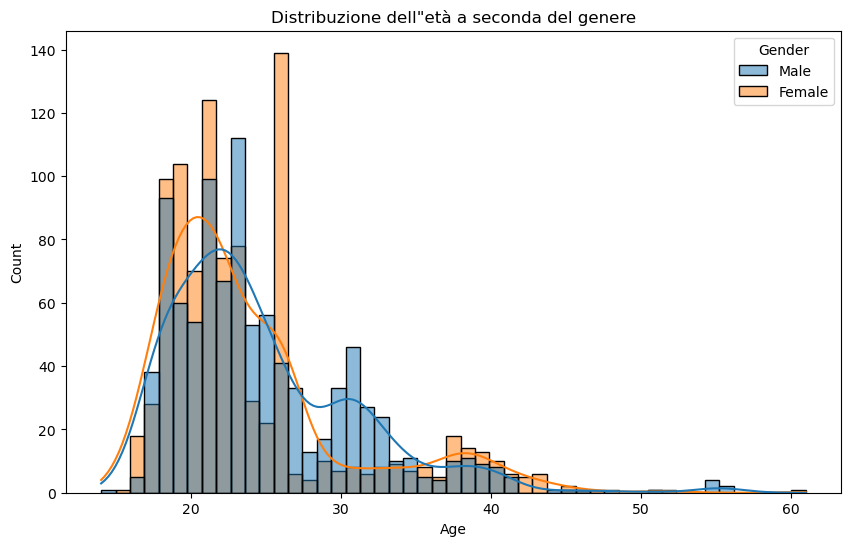

In [133]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset_training, x="Age", kde=True, hue="Gender")
plt.title('Distribuzione dell"età a seconda del genere')
plt.show()

c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

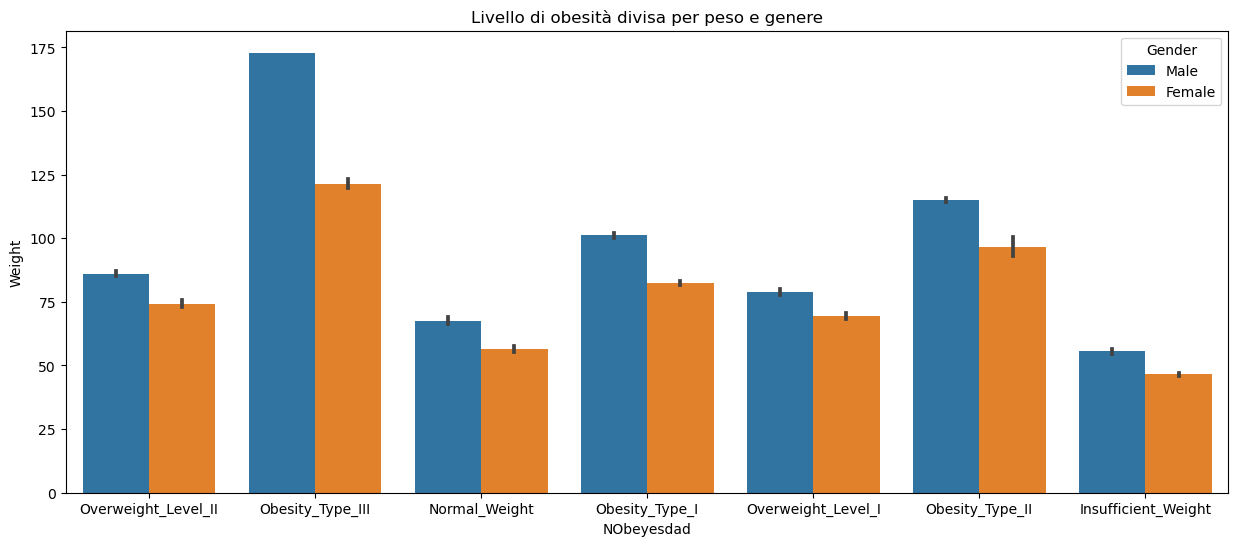

In [134]:
plt.figure(figsize=(15, 6))
sns.barplot(data=dataset_training, x="NObeyesdad", y="Weight", hue="Gender")
plt.title("Livello di obesità divisa per peso e genere")
plt.show()

c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

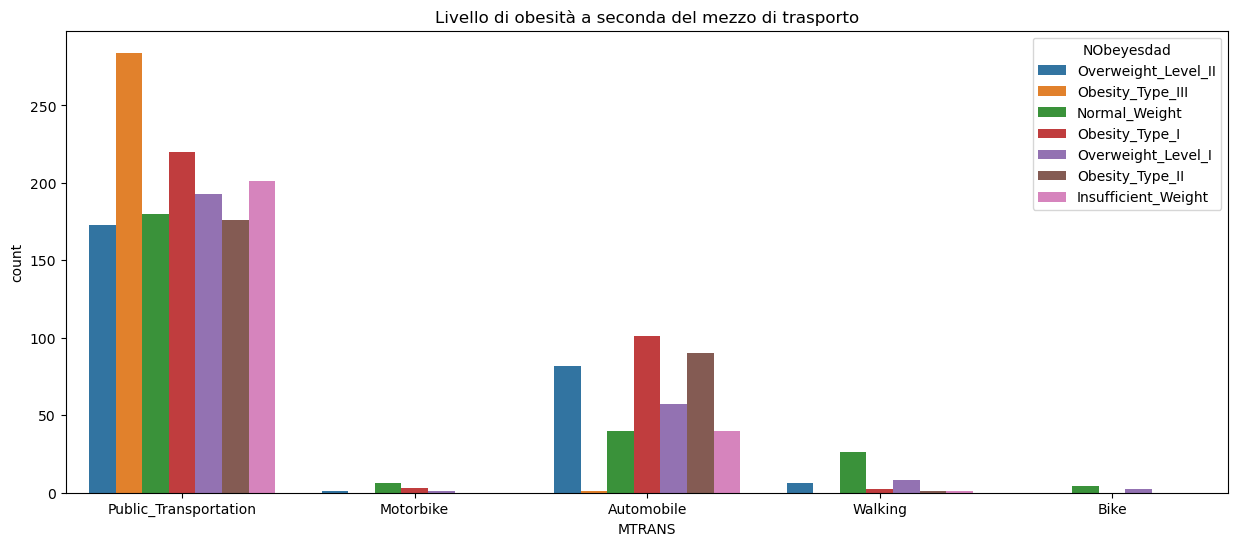

In [135]:
plt.figure(figsize=(15, 6))
sns.countplot(data=dataset_training, x="MTRANS", hue="NObeyesdad")
plt.title("Livello di obesità a seconda del mezzo di trasporto")
plt.show()

c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

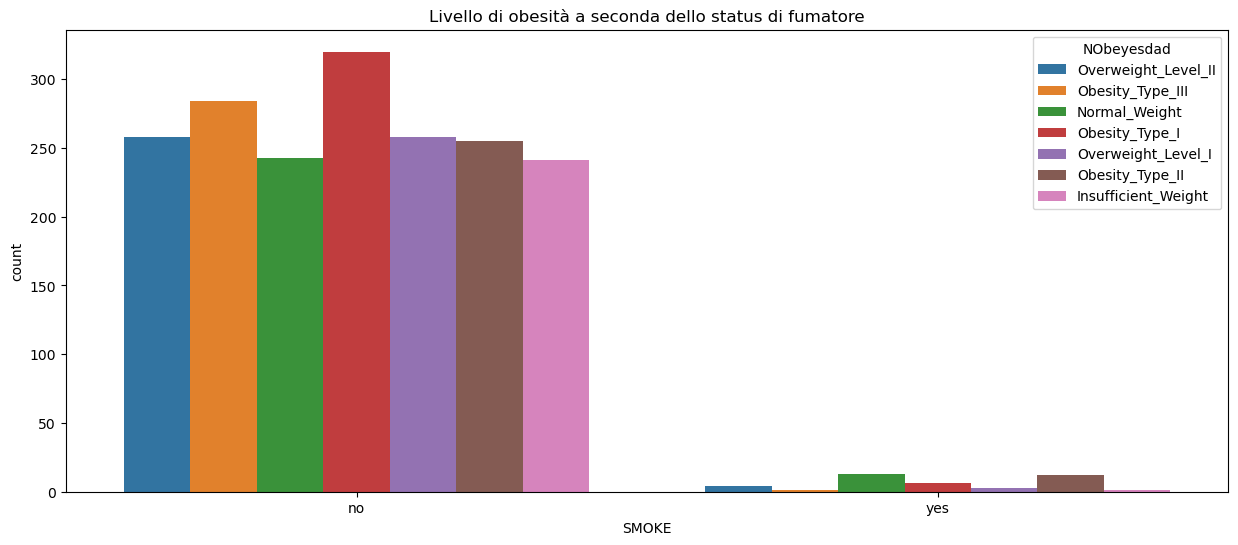

In [136]:
plt.figure(figsize=(15, 6))
sns.countplot(data=dataset_training, x="SMOKE", hue="NObeyesdad")
plt.title("Livello di obesità a seconda dello status di fumatore")
plt.show()

c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alepo\anaconda3\envs\fia\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

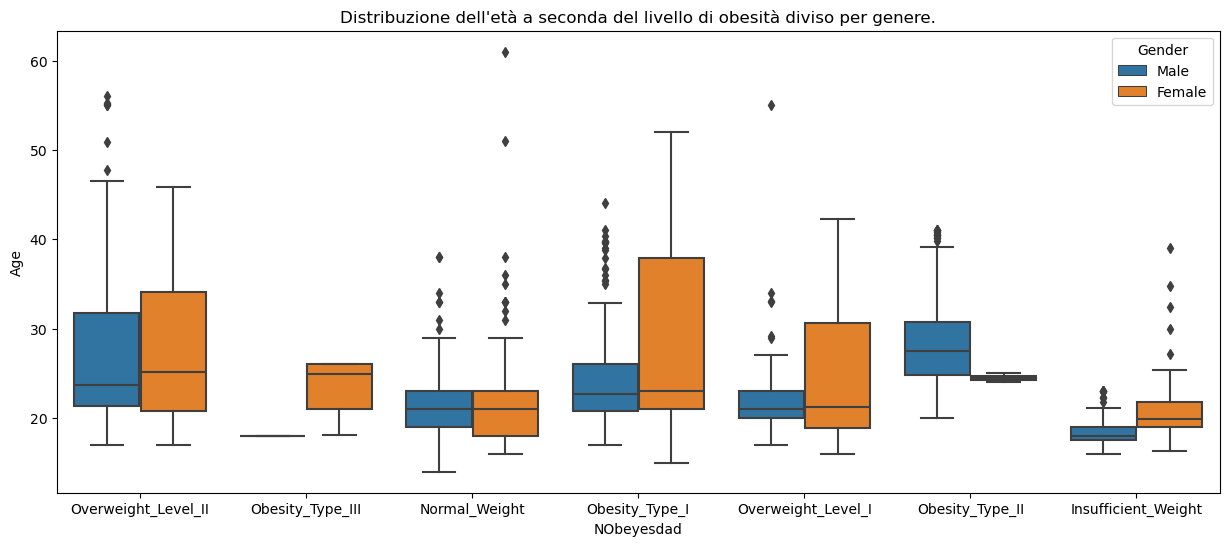

In [137]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataset_training, x="NObeyesdad", y="Age", hue="Gender")
plt.title("Distribuzione dell'età a seconda del livello di obesità diviso per genere.")
plt.show()

## Data preparation


### Implementazione dell'Encoder


La classe `Encoder` serve a trasformare i dati grezzi in un formato adatto all'elaborazione, attraverso:

1. **Gestione dei dati categorici:** Le variabili categoriche, rappresentate da etichette testuali o stringhe che identificano classi distinte, vengono convertite in valori numerici. Ad esempio, la classe potrebbe mappare "Maschio" a 1 e "Femmina" a 0.

2. **Encoding one-hot:** Per le variabili con molteplici categorie vengono create colonne binarie separate per ciascuna categoria. Per la colonna "MTRANS" che rappresenti i mezzi di trasporto ("Bici", "Auto", "Trasporto pubblico", etc.), viene aggiunta una colonna per ogni mezzo (ad esempio, "Bici" = 1 se si utilizza la bicicletta, 0 altrimenti, e colonne analoghe per Auto, Trasporto pubblico, etc.).

3. **Standardizzazione (opzionale):** Questo passaggio mira a normalizzare la scala delle feature, in modo che abbiano media pari a 0 e deviazione standard pari a 1. Ciò garantisce che tutte le feature contribuiscano in modo proporzionale al processo di apprendimento del modello, evitando che quelle con scale più grandi dominino il processo.

4. **Discretizzazione (opzionale):** La discretizzazione raggruppa valori numerici continui in un numero specifico di bin o intervalli.

5. **Preparazione per regressione o classificazione:** Separa i dati in feature (X) e variabile target (Y). Nella regressione, la variabile target è generalmente un valore continuo che si desidera prevedere (il peso). Nella classificazione, è una variabile categorica che si vuole classificare (obeso o non obeso).

6. **Metodi di trasformazione:**
    - `fit_transform`: Questo metodo viene utilizzato quando la classe incontra i dati per la prima volta. Esegue tutte le fasi di encoding, standardizzazione (se specificata) e discretizzazione (se specificata), apprendendo sostanzialmente le trasformazioni dai dati stessi.
    - `transform`: Questo metodo viene utilizzato per incontri successivi con i dati, applica direttamente le fasi di encoding, standardizzazione e discretizzazione apprese ai nuovi dati, preparandoli per il modello.

In [138]:
# Classe per la codifica dei dati

class Encoder:

    def __init__(self, mode, bins=-1, standardization=False):  # Inizializza la classe

        # Controlla che la modalità sia corretta
        assert mode in ["regression", "classification"]

        # Salva le variabili
        self.mode = mode
        self.bins = bins
        self.standardization = standardization
        self.bin_intervals = {}

    def encoding(self, data):  # Codifica i dati in modo che siano utilizzabili per l'addestramento

        # Copia i dati per non modificarli
        data = data.copy()

        # Mappatura delle colonne con valori categorici
        mappings = {
            "Gender": {"Male": 1, "Female": 0},
            "family_history_with_overweight": {"yes": 1, "no": 0},
            "FAVC": {"yes": 1, "no": 0},
            "SMOKE": {"yes": 1, "no": 0},
            "SCC": {"yes": 1, "no": 0},
            "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
            "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
            "NObeyesdad": {
                "Insufficient_Weight": 0,
                "Normal_Weight": 1,
                "Overweight_Level_I": 2,
                "Overweight_Level_II": 3,
                "Obesity_Type_I": 4,
                "Obesity_Type_II": 5,
                "Obesity_Type_III": 6,
            },
        }

        # Mappa i valori
        for col, mapping in mappings.items():
            data[col] = data[col].map(mapping)

        # Codifica il mezzo di trasporto
        activity_types = [
            "Bike",
            "Walking",
            "Public_Transportation",
            "Motorbike",
            "Automobile",
        ]
        for activity in activity_types:
            data[activity] = (data["MTRANS"] == activity).astype(int)
        data = data.drop("MTRANS", axis=1)

        return data


    def standardize(self, X):  # Standardizza i dati e salva la media e la deviazione standard

        # Calcola la media e la deviazione standard
        self.mean = X.mean()
        self.std = X.std()

        # Applica la standardizzazione
        return self.apply_standardization(X)


    def apply_standardization(self, X):  # Applica la standardizzazione
        return (X - self.mean) / self.std

    def discretize(self, data, bins):  # Discretizza i dati in base al numero di bin e salva gli intervalli

        # Discretizza le colonne numeriche
        for col in data.columns:
            if len(data[col].unique()) > bins:

                # Calcola gli intervalli dei bin
                _, bin_edges = pd.cut(data[col], bins=bins, retbins=True, labels=False)

                # Salva gli intervalli dei bin nel dizionario
                self.bin_intervals[col] = bin_edges

                # Discretizza i dati
                data[col] = pd.cut(data[col], bins=bin_edges, labels=range(bins))

        return data

    def apply_discretization(self, data):  # Applica la discretizzazione
        data = data.copy()
        for col in self.bin_intervals.keys():

            # Limita i valori ai bin più estremi per evitare errori
            lower = (self.bin_intervals[col][0] + self.bin_intervals[col][1]) / 2
            upper = (self.bin_intervals[col][-1] + self.bin_intervals[col][-2]) / 2
            data[col] = np.clip(data[col], lower, upper)

            # Discretizza i dati
            data[col] = pd.cut(data[col], bins=self.bin_intervals[col], labels=range(self.bins))
        return data

    def regression(self, data):  # Prepara i dati per la regressione
        X = data.drop("Weight", axis=1)
        Y = data["Weight"]
        return X, Y

    def classification(self, data):  # Prepara i dati per la classificazione
        X = data.drop("NObeyesdad", axis=1)
        Y = (data["NObeyesdad"] > 3).astype(int)
        return X, Y

    def fit_transform(self, data):  # Applica tutte le trasformazioni ai dati

        # Codifica i dati
        data = self.encoding(data)

        # Prepara i dati per la regressione o la classificazione
        X, Y = (self.regression(data) if self.mode == "regression" else self.classification(data))

        # Standardizza i dati se si tratta di una regressione
        if self.standardization:
            X = self.standardize(X)

        # Discretizza i dati se è stato specificato un numero di bin
        if self.bins != -1:
            X = self.discretize(X, self.bins)
            Y = round(Y)

        return X.values, Y.values

    def transform(self, data):  # Applica le trasformazioni ai dati

        # Codifica i dati
        data = self.encoding(data)

        # Prepara i dati per la regressione o la classificazione
        X, Y = (self.regression(data) if self.mode == "regression" else self.classification(data))

        # Standardizza i dati se si tratta di una regressione
        if self.standardization:
            X = self.apply_standardization(X)

        # Discretizza i dati se è stato specificato un numero di bin
        if self.bins != -1:
            X = self.apply_discretization(X)

        return X.values, Y.values

### Metriche


Le funzioni `plot_confusion_matrix`, `plot_roc_curve` e `plot_precision_recall_curve` visualizzano rispettivamente la matrice di confusione, la curva ROC e la curva Precision-Recall. Queste funzioni prendono come input i valori predetti (`y_pred`), i valori reali (`y`) e un oggetto axes di matplotlib (`ax`), e producono un grafico corrispondente.

La funzione `plots` crea una figura con tre sottografici, ognuno dei quali mostra uno dei grafici generati dalle funzioni precedenti.

La funzione `metrics` calcola una serie di metriche a seconda della modalità specificata (`mode`). Se la modalità è "regression", calcola l'errore quadratico medio (MSE), l'errore assoluto medio (MAE) e la radice dell'errore quadratico medio (RMSE). Altrimenti, calcola l'accuratezza, la precisione, il recall, il punteggio F1 e l'AUC, e chiama la funzione `plots` per visualizzare i grafici. Le metriche calcolate vengono poi restituite sotto forma di dizionario.

In [139]:
# Funzioni per il calcolo delle metriche e la visualizzazione dei risultati

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_confusion_matrix(y_pred, y, ax):  # Plotta la matrice di confusione
    cm = confusion_matrix(y_pred, y)
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix")

def plot_roc_curve(y_pred, y, ax):  # Plotta la curva ROC
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, marker=".")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

def plot_precision_recall_curve(y_pred, y, ax):  # Plotta la curva Precision-Recall
    precision_scores, recall_scores, _ = precision_recall_curve(y, y_pred)
    ax.plot(recall_scores, precision_scores, marker=".")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")

def plots(y_pred, y):  # Plotta la matrice di confusione, la curva ROC e la curva Precision-Recall
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    plot_confusion_matrix(y_pred, y, axs[0])
    plot_roc_curve(y_pred, y, axs[1])
    plot_precision_recall_curve(y_pred, y, axs[2])
    plt.tight_layout()
    plt.show()

def metrics(y_pred, y, mode):  # Calcola le metriche in base alla modalitàe ritorna un dizionario con le metriche
    if mode == "regression":
        print("MSE:", mean_squared_error(y_pred, y), "\nMAE:", mean_absolute_error(y_pred, y), "\nRMSE:", np.sqrt(mean_squared_error(y_pred, y)))
        return {"MSE": mean_squared_error(y_pred, y), "MAE": mean_absolute_error(y_pred, y), "RMSE": np.sqrt(mean_squared_error(y_pred, y))}
    else:
        print("Accuracy:", accuracy_score(y_pred, y), "\nPrecision:", precision_score(y_pred, y), "\nRecall:", recall_score(y_pred, y), "\nF1 Score:", f1_score(y_pred, y), "\nAUC:", roc_auc_score(y_pred, y))
        plots(y_pred, y)
        return {"Accuracy": accuracy_score(y_pred, y), "Precision": precision_score(y_pred, y), "Recall": recall_score(y_pred, y), "F1 Score": f1_score(y_pred, y), "\nAUC:": roc_auc_score(y_pred, y)}

### Scelta degli iperparametri


Questa sezione implementa le funzioni per la selezione degli iperparametri dei modelli.

La funzione `cross_validation` esegue la cross-validation k-fold su un modello dato. Divide i dati di input `x` e `y` in `k` fold, addestra il modello su `k-1` fold e valida il modello sul fold rimanente. Questo processo viene ripetuto `k` volte, ogni volta con un fold di validazione diverso. La funzione restituisce la media degli errori di validazione.

La funzione `grid_search` esegue una ricerca su griglia per trovare gli iperparametri ottimali per un modello. Genera tutte le possibili combinazioni degli iperparametri del modello forniti e utilizza la funzione `cross_validation` per valutare il modello per ogni combinazione. La funzione restituisce la combinazione di parametri che ha prodotto l'errore di validazione più basso.

La funzione `model_selection` è una funzione di livello superiore che utilizza la classe `Encoder` per pre-processare i dati, esegue la ricerca su griglia per trovare i parametri ottimali per il modello, addestra il modello con questi parametri e valuta il modello su un set di test. Restituisce i parametri ottimali e le metriche di valutazione.

Infine, la funzione `sklearn_results` è simile a `model_selection`, ma è progettata per funzionare con i modelli sklearn. Addestra il modello sul set di addestramento, fa previsioni sul set di test e valuta le previsioni

In [140]:
def cross_validation(model, x, y, k, loss):  # k-fold cross validation
    size = len(x) // k
    errors = []

    # Itera su ogni fold
    for i in range(k):

        # Divide il dataset in training e validation set
        x_train = np.concatenate((x[: i * size], x[(i + 1) * size :]), axis=0)
        y_train = np.concatenate((y[: i * size], y[(i + 1) * size :]), axis=0)
        x_val = x[i * size : (i + 1) * size]
        y_val = y[i * size : (i + 1) * size]

        # Addestra il modello e calcola l'errore
        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        error = loss(predictions, y_val)
        errors.append(error)

    # Restituisce l'errore medio
    return np.mean(errors)

def grid_search(x, y, model_class, model_params, k, loss, verbose):  # Grid search per la ricerca dei parametri ottimali

    # Generate all possible combinations of model parameters
    values = [model_params[param] for param in model_params]
    combinations = list(itertools.product(*values))
    errors = []

    # Se c'è solo una combinazione di parametri, restituisci quella
    if len(combinations) == 1:
        return combinations[0]

    # Itera su ogni combinazione di parametri
    for combo in combinations:

        # Calcola l'errore
        error = cross_validation(model_class(*combo), x, y, k, loss)

        # Salva l'errore
        errors.append(error)

        # Stampa il progresso
        if verbose:
            print(f"  >> Combo: {combo} >> Error: {error}")

    # Trova la combinazione di parametri con l'errore minore
    combo_optim = combinations[np.argmin(errors)]

    # Stampa i parametri ottimali
    if verbose:
            print(f"  => Optimal combo: {combo_optim} >>")

    return combo_optim

def model_selection(model_class, model_params, mode, k=5, loss=mean_squared_error, bins=-1, verbose=False, standardization=False,):  # Model selection tramite k-fold cross validation

    # Controlla che la modalità sia corretta
    assert mode in ["regression", "classification"]

    # Divide il dataset in training e test set
    encoder = Encoder(mode, bins, standardization)
    x_train, y_train = encoder.fit_transform(dataset_training)
    x_test, y_test = encoder.transform(dataset_test)

    # Cerca i parametri ottimali
    combo_optim = grid_search(x_train, y_train, model_class, model_params, k, loss, verbose)

    # Addestra il modello con i parametri ottimali e calcola l'errore sul test set
    model = model_class(*combo_optim)
    errori = model.fit(x_train, y_train, verbose)    
    y_pred = model.predict(x_test)

    # Dizionario dei parametri ottimali
    params = {param: combo_optim[i] for i, param in enumerate(model_params)}

    # Plotta gli errori durante l'addestramento
    if verbose and errori is not None and errori != []:
        plt.plot(errori)
        plt.xlabel("Iterazione")
        plt.ylabel("Errore")
        plt.title("Errore durante l'addestramento")
        plt.show()

    # Restituisce i parametri ottimali e le metriche
    return params, metrics(y_pred, y_test, mode)


def sklearn_results(model, mode, bins=-1, standardization=False, round=False):  # Addestra il modello e calcola le metriche per modelli di sklearn

    # Divide il dataset in training e test set
    encoder = Encoder(mode, bins, standardization)
    x_train, y_train = encoder.fit_transform(dataset_training)
    x_test, y_test = encoder.transform(dataset_test)

    # Addestra il modello e calcola le metriche
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Arrotonda i valori se si tratta di una classificazione binaria
    if round:
        y_pred = (y_pred > 0.5).astype(int)

    metrics(y_pred, y_test, mode)

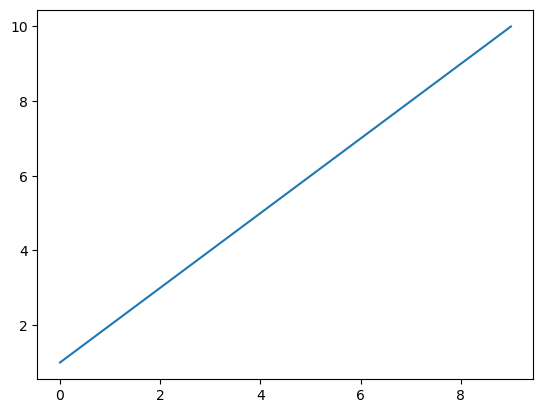

In [141]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## Model training


### Linear Regression


La seguente classe implementa un modello di regressione lineare. La regressione lineare è un metodo statistico utilizzato per modellare la relazione tra una variabile dipendente e una o più variabili indipendenti. Il modello di regressione lineare può essere espresso come:

$$y = Xw + c$$

dove:
- $y$ è la variabile dipendente.
- $X$ è la matrice delle variabili indipendenti.
- $w$ è il vettore dei pesi.
- $c$ è il vettore dei coefficienti.

Il modello cerca di minimizzare la funzione di perdita, che è la somma dei quadrati degli errori:

$$Loss(w) = \sum_{i=1}^{n}(y_i - (x_i^Tw + c))^2$$

dove $n$ è il numero di osservazioni.

Se si utilizza la discesa del gradiente per ottimizzare la funzione di perdita, i pesi vengono aggiornati iterativamente secondo la regola:

$$w = w - \alpha \nabla L(w)$$

dove:
- $\alpha$ è il tasso di apprendimento.
- $\nabla Loss(w)$ è il gradiente della funzione di perdita rispetto ai pesi.

Se si utilizza la soluzione analitica, i pesi vengono calcolati come:

$$w = (X^TX)^{-1}X^Ty$$

Nel caso della classificazione, viene applicata una soglia alla predizione per ottenere la classe prevista. Nel codice, la soglia è 0 se si utilizza la discesa del gradiente, altrimenti è 0.5.

Il codice supporta anche la discesa del gradiente stocastica, che utilizza un sottoinsieme casuale dei dati ad ogni iterazione, e la regolarizzazione L1 e L2, che aggiungono un termine di penalità alla funzione di perdita per prevenire l'overfitting. La regolarizzazione L1 e L2 sono definite come:

$$L1(w) = \lambda_1 ||w||_1$$
$$L2(w) = \lambda_2 ||w||_2^2$$

dove $\lambda_1$ e $\lambda_2$ sono i parametri di regolarizzazione, e $||\cdot||_1$ e $||\cdot||_2$ sono le norme L1 e L2, rispettivamente. La funzione di perdita con la regolarizzazione diventa:

$$Loss(w) = \sum_{i=1}^{n}(y_i - (x_i^Tw + c))^2 + \lambda_1 ||w||_1 + \lambda_2 ||w||_2^2$$

#### Implementazione


In [142]:
# Implementazione del modello di regressione lineare

class MyLinearRegressor:
    def __init__(self, mode, alpha=-1, lambda1=0.1, lambda2=0.1, num_iterations=1000, cutoff=0.01, batch=-1):
        self.mode = mode

        # Se alpha è -1, allora si utilizza la soluzione analitica
        self.gradient_descent = alpha != -1

        # Se si usa la discesa del gradiente, il threshold è 0, altrimenti è 0.5
        self.thresh = 0 if self.gradient_descent else 0.5

        # Altrimenti si utilizza la discesa del gradiente
        if alpha != -1:
            self.lambda1 = lambda1
            self.lambda2 = lambda2
            self.num_iterations = num_iterations
            self.cutoff = cutoff
            self.alpha = alpha

            # Se batch è -1, allora si utilizza la discesa del gradiente stocastica
            self.stocastic = batch != -1

            # Altrimenti si utilizza la discesa del gradiente batch
            self.batch = batch

    def threshold(self, z): # Applica la soglia per la classificazione
        return (z > self.thresh).astype(int)

    def concat_ones(self, X): # Aggiunge una colonna di 1 per il termine noto
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    def get_random_batch(self, X, Y): # Prende un batch casuale di dimensione batch
        indices = np.random.choice(np.arange(X.shape[0]), size=self.batch, replace=False)
        return X[indices], Y[indices]

    def gradient(self, x, y, verbose): # Calcola il gradiente

        # Se è stata specificata una dimensione del batch, prende un batch casuale
        if self.stocastic:
            x, y = self.get_random_batch(x, y)

        # Calcola la predizione
        y_pred = np.dot(self.w, x.T)

        # Se si tratta di una classificazione, applica la soglia
        if self.mode == "classification":
            y_pred = self.threshold(y_pred)

        # Aggiungi errori alla lista per la visualizzazione
        if verbose:
            self.errori.append(mean_squared_error(y_pred, y))

        # Calcola il gradiente della funzione di perdita
        return np.dot((y - y_pred), x)

    def fit_gradient_descent(self, X, Y, verbose): # Addestra il modello con la discesa del gradiente

        # Inizializza i pesi con valori casuali
        self.w = np.zeros(X.shape[1])

        # Addestra il modello
        for _ in range(self.num_iterations):
            prev_w = self.w.copy()

            # Calcola il gradiente
            gradient = self.gradient(X, Y, verbose)

            # Aggiorna i pesi
            self.w += self.alpha * (gradient + self.lambda1 * np.sign(self.w) + self.lambda2 * self.w)

            # Controlla la convergenza
            max_diff = np.max(np.abs(self.w - prev_w))
            if max_diff < self.cutoff:
                break

        return self.errori

    def fit_analytical(self, X, Y): # Addestra il modello con la soluzione analitica
        # La funzione np.linalg.solve calcola la soluzione di un sistema lineare in modo più efficiente rispetto all'inversione della matrice
        self.w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y)).reshape(-1)

    def fit(self, X, Y, verbose = False): # Addestra il modello
        self.errori = []

        # Aggiunge una colonna di 1 per il termine noto
        X = self.concat_ones(X)

        # Addestra il modello con la discesa del gradiente o con la soluzione analitica
        if self.gradient_descent:
            return self.fit_gradient_descent(X, Y, verbose)
        return self.fit_analytical(X, Y)

    def predict(self, X): # Predice i valori
        X = self.concat_ones(X)
        y_pred = np.dot(self.w, X.T)
        return y_pred if self.mode == "regression" else self.threshold(y_pred)

#### Regressione


In [143]:
# Valutazione del modello con equazione normale

# Il mio modello

model_params = {
    "mode": ["regression"]
    }

print("Metriche per la regressione lineare con equazione normale")
optim_params["Linear Regression"], regression_results["Linear Regression"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LinearRegression

model = LinearRegression()

print("\nMetriche per la regressione lineare con equazione normale di sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con equazione normale
MSE: 26.515841099863362 
MAE: 4.033584800480725 
RMSE: 5.149353464257757

Metriche per la regressione lineare con equazione normale di sklearn
MSE: 26.515841099863433 
MAE: 4.033584800480732 
RMSE: 5.149353464257763


Metriche per la regressione lineare con discesa del gradiente
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.1) >> Error: 444.80125089173305
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.01) >> Error: 444.80125089173305
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.001) >> Error: 444.80125089173305
  >> Combo: ('regression', 1e-05, 0, 0, 1000, 0.1) >> Error: 98.27514392753531
  >> Combo: ('regression', 1e-05, 0, 0, 1000, 0.01) >> Error: 33.39429890417831
  >> Combo: ('regression', 1e-05, 0, 0, 1000, 0.001) >> Error: 30.650609879792647
  >> Combo: ('regression', 1e-05, 0, 0, 10000, 0.1) >> Error: 98.27514392753531
  >> Combo: ('regression', 1e-05, 0, 0, 10000, 0.01) >> Error: 33.39429890417831
  >> Combo: ('regression', 1e-05, 0, 0, 10000, 0.001) >> Error: 30.650609879792647
  >> Combo: ('regression', 0.0001, 0, 0, 100, 0.1) >> Error: 32.98757681120076
  >> Combo: ('regression', 0.0001, 0, 0, 100, 0.01) >> Error: 30.649131215063687
  >> Combo: ('regression', 0.0001, 0, 0, 100, 0.001) 

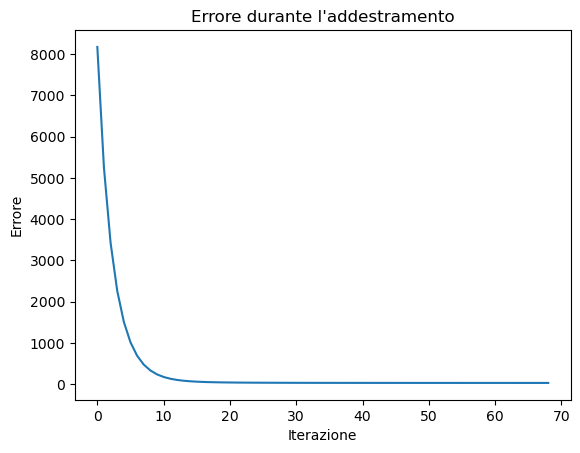

MSE: 26.230398486061713 
MAE: 4.003061448529706 
RMSE: 5.121562113853713


In [144]:
# Valutazione del modello con discesa del gradiente

model_params = {
    "mode": ["regression"],
    "alpha": [10**i for i in range(-5, -3)],
    "lambda1": [0],     # Non regolarizzato
    "lambda2": [0],     # Non regolarizzato
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.1, 0.01, 0.001],
}

print("Metriche per la regressione lineare con discesa del gradiente")
optim_params["Linear Regression GD"], regression_results["Linear Regression GD"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression", verbose=True)

Metriche per la regressione lineare con discesa del gradiente stocastica
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.1, 20) >> Error: 8169.5245914098805
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.1, 50) >> Error: 8164.838167814129
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.1, 100) >> Error: 8156.398220126246
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.01, 20) >> Error: 7839.0496772557435
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.01, 50) >> Error: 7363.722469953308
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.01, 100) >> Error: 6635.774064518817
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.001, 20) >> Error: 7836.934136556983
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.001, 50) >> Error: 7357.846695151937
  >> Combo: ('regression', 1e-05, 0, 0, 100, 0.001, 100) >> Error: 6639.477202365959
  >> Combo: ('regression', 1e-05, 0, 0, 1000, 0.1, 20) >> Error: 8170.090145843307
  >> Combo: ('regression', 1e-05, 0, 0, 1000, 0.1, 50) >> Error: 8164.681389158724
  >> Comb

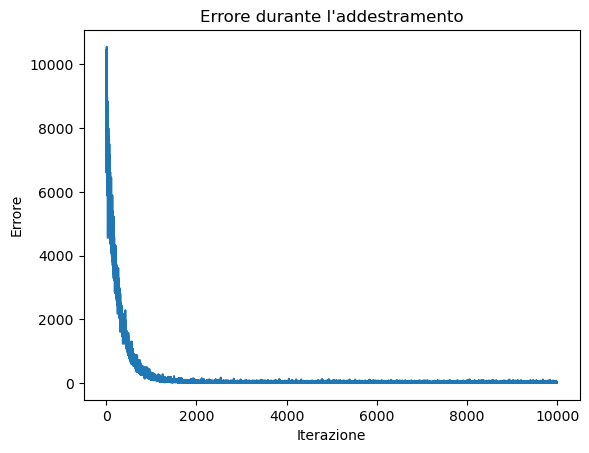

MSE: 26.741480790141644 
MAE: 4.059343037536764 
RMSE: 5.17121656770838

Metriche per la regressione lineare con discesa del gradiente stocastica con sklearn
MSE: 26.342501666639297 
MAE: 4.016115247351868 
RMSE: 5.132494682572919


In [145]:
# Valutazione del modello con discesa del gradiente stocastica

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [10**i for i in range(-5, -3)],
    "lambda1": [0],     # Non regolarizzato
    "lambda2": [0],     # Non regolarizzato
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.1, 0.01, 0.001],
    "batch": [20, 50, 100],
}

print("Metriche per la regressione lineare con discesa del gradiente stocastica")
optim_params["Linear Regression SGD"], regression_results["Linear Regression SGD"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression", verbose=True)


# Il modello di sklearn

from sklearn.linear_model import SGDRegressor

max_iter = optim_params["Linear Regression SGD"]["num_iterations"]
alpha = optim_params["Linear Regression SGD"]["alpha"]
tol = optim_params["Linear Regression SGD"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty=None)

print("\nMetriche per la regressione lineare con discesa del gradiente stocastica con sklearn")
sklearn_results(model, "regression", standardization=True)

##### Regolarizzazioni


Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1
  >> Combo: ('regression', 1e-05, 0.1, 0, 100, 0.1) >> Error: 444.80049350001656
  >> Combo: ('regression', 1e-05, 0.1, 0, 100, 0.01) >> Error: 444.80049350001656
  >> Combo: ('regression', 1e-05, 0.1, 0, 100, 0.001) >> Error: 444.80049350001656
  >> Combo: ('regression', 1e-05, 0.1, 0, 1000, 0.1) >> Error: 98.27546192252684
  >> Combo: ('regression', 1e-05, 0.1, 0, 1000, 0.01) >> Error: 33.394763405625355
  >> Combo: ('regression', 1e-05, 0.1, 0, 1000, 0.001) >> Error: 30.650832961273856
  >> Combo: ('regression', 1e-05, 0.1, 0, 10000, 0.1) >> Error: 98.27546192252684
  >> Combo: ('regression', 1e-05, 0.1, 0, 10000, 0.01) >> Error: 33.394763405625355
  >> Combo: ('regression', 1e-05, 0.1, 0, 10000, 0.001) >> Error: 30.650832961273856
  >> Combo: ('regression', 0.0001, 0.1, 0, 100, 0.1) >> Error: 32.98803547146885
  >> Combo: ('regression', 0.0001, 0.1, 0, 100, 0.01) >> Error: 30.649358761764944
  >> Co

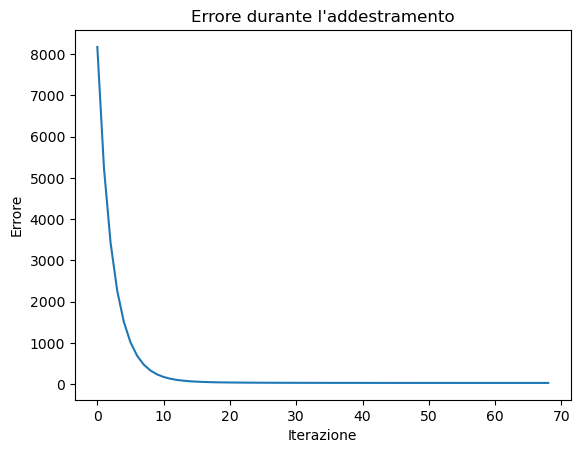

MSE: 26.230959809154125 
MAE: 4.0031157893357445 
RMSE: 5.121616913549287

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 di sklearn
MSE: 25.97490237109225 
MAE: 3.971983478028294 
RMSE: 5.096557894411899


In [146]:
# Valutazione del modello con discesa del gradiente e regolarizzazione L1

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [10**i for i in range(-5, -3)],
    "lambda1": [0.1],
    "lambda2": [0],  # Deve essere 0 per la L1
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.1, 0.01, 0.001],
}

print("Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1")
optim_params["Linear Regression GD Lasso"], regression_results["Linear Regression GD Lasso"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression", verbose=True)


# Il modello di sklearn

max_iter = optim_params["Linear Regression GD Lasso"]["num_iterations"]
alpha = optim_params["Linear Regression GD Lasso"]["alpha"]
tol = optim_params["Linear Regression GD Lasso"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty="l1", l1_ratio=1)

print("\nMetriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 di sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L2
  >> Combo: ('regression', 1e-05, 0, 0.1, 100, 0.1) >> Error: 444.69980844086285
  >> Combo: ('regression', 1e-05, 0, 0.1, 100, 0.01) >> Error: 444.69980844086285
  >> Combo: ('regression', 1e-05, 0, 0.1, 100, 0.001) >> Error: 444.69980844086285
  >> Combo: ('regression', 1e-05, 0, 0.1, 1000, 0.1) >> Error: 98.21467531608332
  >> Combo: ('regression', 1e-05, 0, 0.1, 1000, 0.01) >> Error: 33.38665619256287
  >> Combo: ('regression', 1e-05, 0, 0.1, 1000, 0.001) >> Error: 30.65035560672078
  >> Combo: ('regression', 1e-05, 0, 0.1, 10000, 0.1) >> Error: 98.21467531608332
  >> Combo: ('regression', 1e-05, 0, 0.1, 10000, 0.01) >> Error: 33.38665619256287
  >> Combo: ('regression', 1e-05, 0, 0.1, 10000, 0.001) >> Error: 30.65035560672078
  >> Combo: ('regression', 0.0001, 0, 0.1, 100, 0.1) >> Error: 32.98150649575392
  >> Combo: ('regression', 0.0001, 0, 0.1, 100, 0.01) >> Error: 30.64901229390407
  >> Combo: 

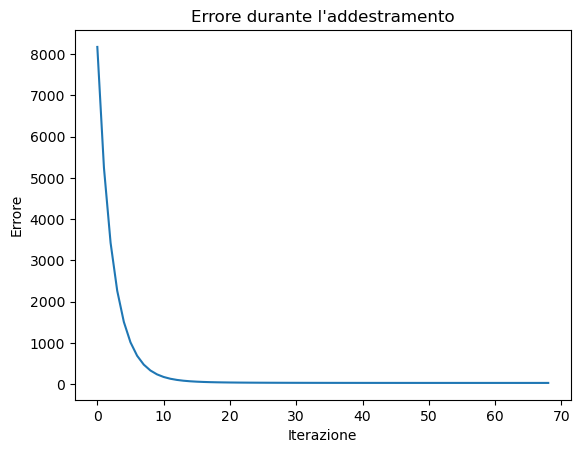

MSE: 26.236951955868033 
MAE: 4.0034472192809805 
RMSE: 5.122201865981858

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L2 di sklearn
MSE: 25.927283825236493 
MAE: 3.9668215547751826 
RMSE: 5.09188411349242


In [147]:
# Valutazione del modello con discesa del gradiente e regolarizzazione L2

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [10**i for i in range(-5, -3)],
    "lambda1": [0],  # Deve essere 0 per la L2
    "lambda2": [0.1],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.1, 0.01, 0.001],
}
print("Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L2")
optim_params["Linear Regression GD Ridge"], regression_results["Linear Regression GD Ridge"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression", verbose=True)

# Il modello di sklearn

max_iter = optim_params["Linear Regression GD Ridge"]["num_iterations"]
alpha = optim_params["Linear Regression GD Ridge"]["alpha"]
tol = optim_params["Linear Regression GD Ridge"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty="l2", l1_ratio=0)

print("\nMetriche per la regressione lineare con discesa del gradiente e regolarizzazione L2 di sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 100, 0.1) >> Error: 444.69905137110965
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 100, 0.01) >> Error: 444.69905137110965
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 100, 0.001) >> Error: 444.69905137110965
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 1000, 0.1) >> Error: 98.21499382713273
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 1000, 0.01) >> Error: 33.38712144634727
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 1000, 0.001) >> Error: 30.6505701974066
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 10000, 0.1) >> Error: 98.21499382713273
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 10000, 0.01) >> Error: 33.38712144634727
  >> Combo: ('regression', 1e-05, 0.1, 0.1, 10000, 0.001) >> Error: 30.6505701974066
  >> Combo: ('regression', 0.0001, 0.1, 0.1, 100, 0.1) >> Error: 32.98196572072921
  >> Combo: ('regression', 0.0001, 0.1, 0.1, 100, 0.01) >> Error: 30.64

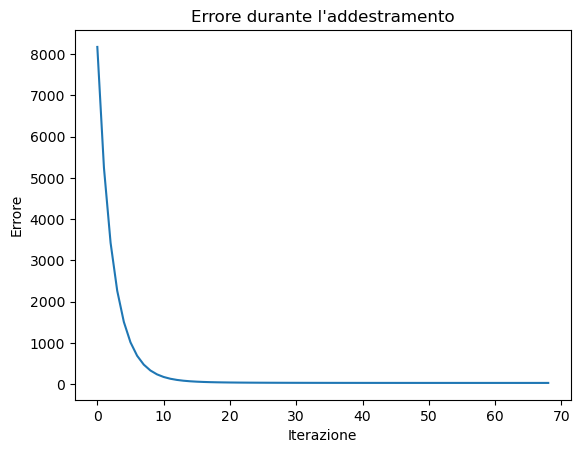

MSE: 26.23751468640832 
MAE: 4.003501564223599 
RMSE: 5.122256796218667

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2 di sklearn
MSE: 25.9592230637872 
MAE: 3.9705942934678182 
RMSE: 5.095019437037233


In [148]:
# Valutazione del modello con discesa del gradiente e regolarizzazione L1 e L2

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [10**i for i in range(-5, -3)],
    "lambda1": [0.1],
    "lambda2": [0.1],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.1, 0.01, 0.001],
}

print("Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2")
optim_params["Linear Regression GD Elastic Net"], regression_results["Linear Regression GD Elastic Net"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression", verbose=True)

# Il modello di sklearn

max_iter = optim_params["Linear Regression GD Elastic Net"]["num_iterations"]
alpha = optim_params["Linear Regression GD Elastic Net"]["alpha"]
tol = optim_params["Linear Regression GD Elastic Net"]["cutoff"]
l1_ratio = optim_params["Linear Regression GD Elastic Net"]["lambda1"] / (optim_params["Linear Regression GD Elastic Net"]["lambda1"] + optim_params["Linear Regression GD Elastic Net"]["lambda2"])

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty="elasticnet", l1_ratio=l1_ratio)

print("\nMetriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2 di sklearn")
sklearn_results(model, "regression", standardization=True)


#### Classificazione


al secondo se non compatibili gli alpha


Metriche per la classificazione con regressione lineare e equazione normale
Accuracy: 0.9622641509433962 
Precision: 0.9574468085106383 
Recall: 0.9574468085106383 
F1 Score: 0.9574468085106385 
AUC: 0.9617742517129464


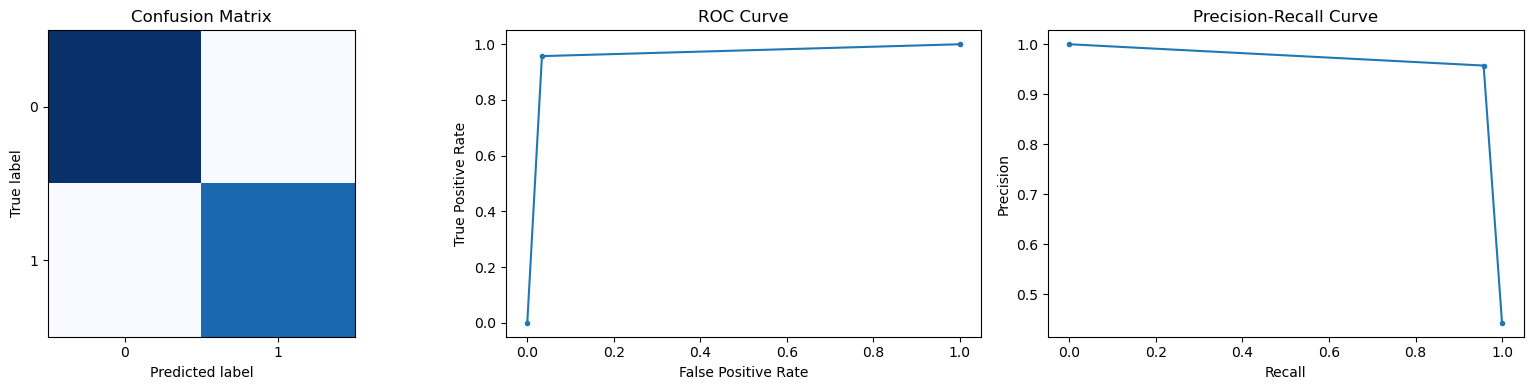


Metriche per la classificazione con regressione lineare e equazione normale di sklearn
Accuracy: 0.9622641509433962 
Precision: 0.9574468085106383 
Recall: 0.9574468085106383 
F1 Score: 0.9574468085106385 
AUC: 0.9617742517129464


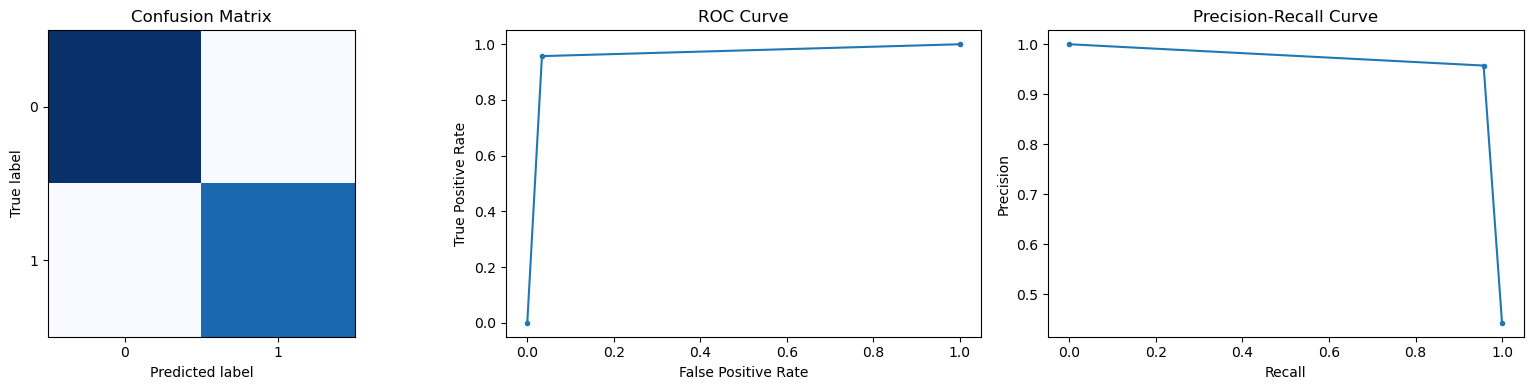

In [153]:
# Valutazione del modello con equazione normale per la classificazione

# Il mio modello

model_params = {"mode": ["classification"]}

print("Metriche per la classificazione con regressione lineare e equazione normale")
optim_params["Linear Regression"], classification_results["Linear Regression"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LinearRegression

model = LinearRegression()

print("\nMetriche per la classificazione con regressione lineare e equazione normale di sklearn")
sklearn_results(model, "classification", standardization=True, round=True)

Metriche per la classificazione con regressione lineare e discesa del gradiente
  >> Combo: ('classification', 1e-05, 0, 0, 100, 0.001, 20) >> Error: 0.32664907651715036
  >> Combo: ('classification', 1e-05, 0, 0, 100, 0.001, 50) >> Error: 0.2712401055408971
  >> Combo: ('classification', 1e-05, 0, 0, 100, 0.001, 100) >> Error: 0.26701846965699205
  >> Combo: ('classification', 1e-05, 0, 0, 100, 0.0001, 20) >> Error: 0.2532981530343008
  >> Combo: ('classification', 1e-05, 0, 0, 100, 0.0001, 50) >> Error: 0.13773087071240103
  >> Combo: ('classification', 1e-05, 0, 0, 100, 0.0001, 100) >> Error: 0.07968337730870713
  >> Combo: ('classification', 1e-05, 0, 0, 100, 1e-05, 20) >> Error: 0.0891820580474934
  >> Combo: ('classification', 1e-05, 0, 0, 100, 1e-05, 50) >> Error: 0.03852242744063324
  >> Combo: ('classification', 1e-05, 0, 0, 100, 1e-05, 100) >> Error: 0.016886543535620052
  >> Combo: ('classification', 1e-05, 0, 0, 1000, 0.001, 20) >> Error: 0.29234828496042214
  >> Combo: ('c

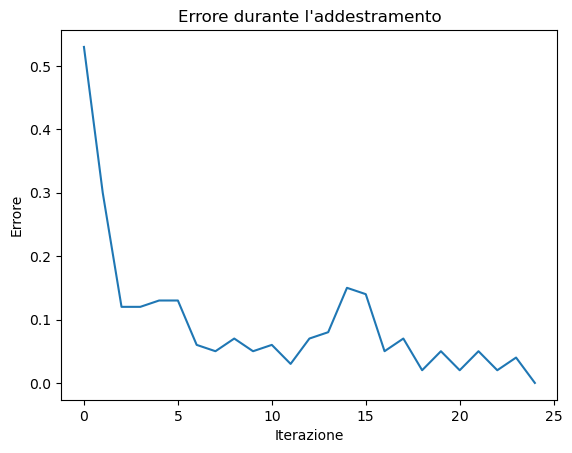

Accuracy: 0.9811320754716981 
Precision: 0.9680851063829787 
Recall: 0.9891304347826086 
F1 Score: 0.9784946236559139 
AUC: 0.9820652173913043


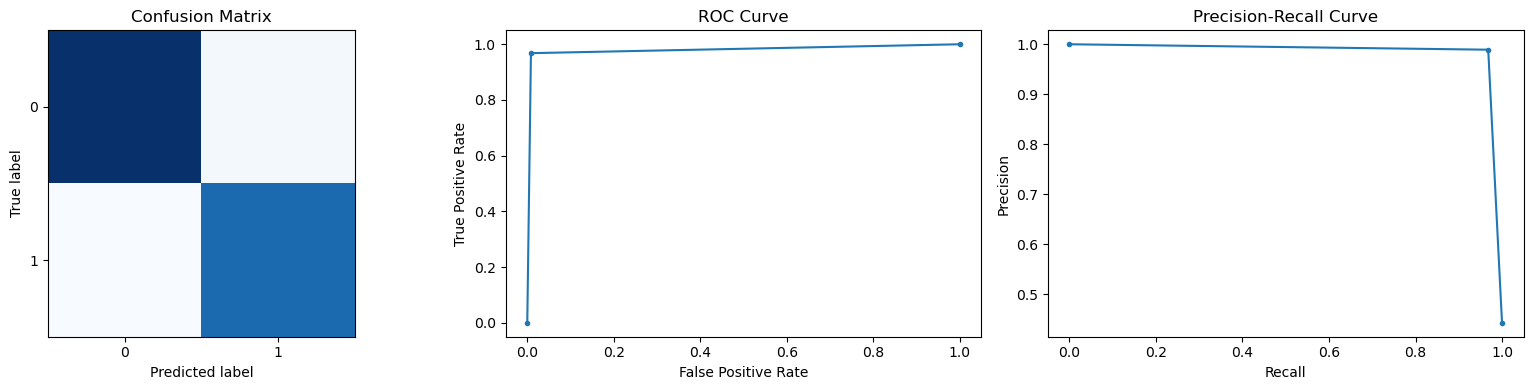


Metriche per la classificazione con regressione lineare e discesa del gradiente di sklearn
Accuracy: 0.9716981132075472 
Precision: 0.9680851063829787 
Recall: 0.9680851063829787 
F1 Score: 0.9680851063829787 
AUC: 0.9713306887847096


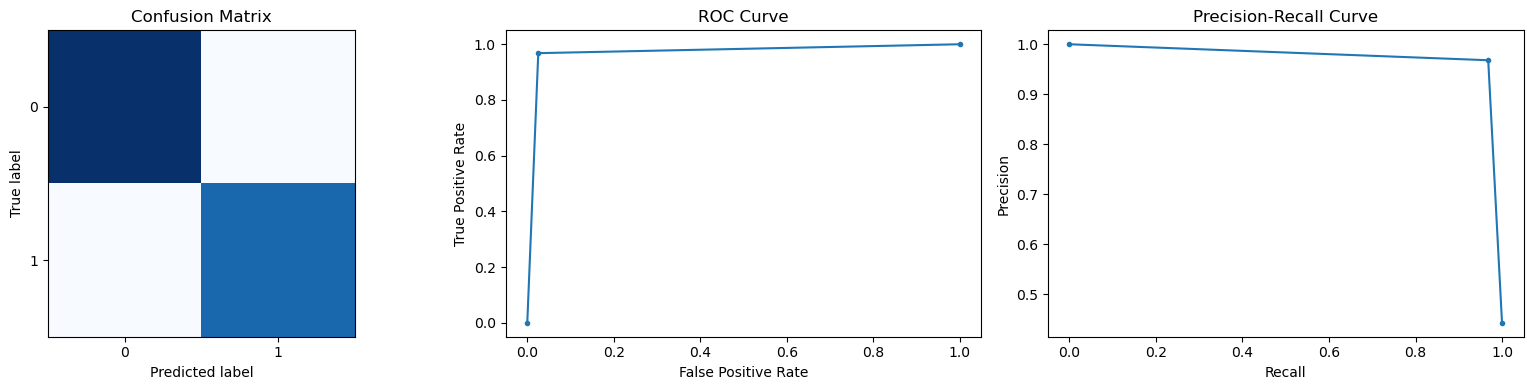

In [154]:
# Valutazione del modello con discesa del gradiente stocastico per la classificazione

# Il mio modello

model_params = {
    "mode": ["classification"],
    "alpha": [10**i for i in range(-5, -3)],
    "lambda1": [0],
    "lambda2": [0],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.001, 0.0001, 0.00001],
    "batch": [20, 50, 100],
    }

print("Metriche per la classificazione con regressione lineare e discesa del gradiente")
optim_params["Linear Regression GD"], classification_results["Linear Regression GD"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import SGDRegressor

max_iter = optim_params["Linear Regression GD"]["num_iterations"]
alpha = optim_params["Linear Regression GD"]["alpha"]
tol = optim_params["Linear Regression GD"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, tol=tol)

print("\nMetriche per la classificazione con regressione lineare e discesa del gradiente di sklearn")
sklearn_results(model, "classification", standardization=True, round=True)

### Desicion Tree


Questa classe implementa un albero di decisione, che predice il valore di una variabile target in base a diverse variabili di input. Ogni nodo interno dell'albero corrisponde a una delle variabili di input, ogni ramo rappresenta una decisione e ogni foglia rappresenta un risultato, il valore della variabile target.

La costruzione dell'albero di decisione avviene in modo ricorsivo. Ad ogni passaggio, l'algoritmo sceglie la variabile che fornisce il massimo guadagno di informazione. Il guadagno di informazione è calcolato come la differenza tra l'entropia prima e dopo la divisione dei dati sulla base di una variabile. L'entropia è una misura dell'incertezza o dell'impurità nei dati, definita come:

$$B(q) = -(q \log_2(q) + (1 - q) \log_2(1 - q))$$

dove $q$ è la probabilità che una variabile booleana casuale sia vera.

L'entropia dell'output su tutto l'insieme è calcolata come:

$$H(Output) = B\left(\frac{p}{p+n}\right)$$

dove $p$ è il numero di esempi positivi e $n$ è il numero di esempi negativi.

L'entropia attesa rimanente dopo il test dell'attributo $A$ è calcolata come:

$$Remainder(A) = \sum \left(\frac{p_k+n_k}{p+n}\right) B\left(\frac{p_k}{p_k+n_k}\right)$$

dove $p_k$ è il numero di esempi positivi e $n_k$ è il numero di esempi negativi per il valore $k$ dell'attributo $A$.

Il guadagno di informazione dall'attributo test su $A$ è la riduzione attesa nell'entropia:

$$Gain(A) = B\left(\frac{p}{p+n}\right) - Remainder(A)$$

dove il primo termine corrisponde all'entropia prima della divisione e il secondo all'entropia dopo la divisione.

L'algoritmo continua a dividere i dati sulla base della variabile che fornisce il massimo guadagno di informazione fino a quando non si raggiunge una condizione di arresto, come una profondità massima dell'albero, l'assenza di esempi o attributi o il caso in cui tutti gli esempi abbiano lo stesso valore di target, restituendo quello più ricorrente.

Una volta costruito l'albero, le previsioni possono essere fatte navigando l'albero con le variabili di input di un esempio fino a raggiungere un nodo foglia, che fornisce la previsione. Nel caso della classificazione, la previsione è la classe più comune tra gli esempi nel nodo foglia. Nel caso della regressione, i valori di target devono essere discretizzati e la previsione è l sempre il valore target nel nodo foglia. Infine, nel caso il valore corrispondente ad un attributo non sia presente nell'albero appreso durante la predizione, viene scelto il valore più ricorrente per l'attributo.

#### Implementazione


In [158]:
# Implementazione di un albero di decisione

class MyDesicionTreeClassifier:

    def __init__(self, h_max=None):
        self.h_max = h_max  # massima profondità dell'albero

    def entropy(self, q):  # calcola l'entropia per un dato valore di probabilità q
        if q <= 0 or q >= 1:
            return 0
        return -(q * np.log2(q) + (1 - q) * np.log2(1 - q))

    def plurality_value(self, examples):  # restituisce la classe più comune tra gli esempi
        return round(np.mean(examples[:, -1]))

    def same_classification(self, examples):  # controlla se tutti gli esempi appartengono alla stessa classe
        return np.all(examples[:, -1] == examples[0, -1])

    def pos_neg_examples(self, array):  # conta il numero di esempi positivi e negativi
        pos = np.sum(array)
        return pos, len(array) - pos

    def fit(self, X, Y, verbose = False):  # addestra l'albero di decisione

        # controlla se h_max è None
        if self.h_max == None:
            self.h_max = X.shape[1]

        # inizializza l'albero di decisione
        attributes = list(range(X.shape[1]))
        examples = np.concatenate((X, Y.reshape(-1, 1)), axis=1)

        # apprende l'albero di decisione
        self.tree = self.learn_decision_tree(examples, attributes, examples, self.h_max)

    def most_important(self, examples, attributes):  # trova l'attributo più importante (con il massimo guadagno di informazione)

        # calcola l'entropia dell'output
        pos, neg = self.pos_neg_examples(examples[:, -1])
        H_output = self.entropy(pos / (pos + neg))
        gain = []

        # calcola il guadagno di informazione per ogni attributo
        for attribute in attributes:
            pos, neg = self.pos_neg_examples(examples[:, attribute])
            remainder = 0

            # calcola l'entropia residua
            for value in set(examples[:, attribute]):
                exs = examples[examples[:, attribute] == value]
                pos_v, neg_v = self.pos_neg_examples(exs[:, -1])
                remainder += ((pos_v + neg_v) / (pos + neg)) * self.entropy(pos_v / (pos_v + neg_v))

            # calcola il guadagno di informazione
            gain.append(H_output - remainder)

        # restituisce l'attributo con il massimo guadagno
        return attributes[np.argmax(gain)]

    def get_values(self, array):  # restituisce i valori unici di un array in ordine di occorrenza
        return sorted(set(array), key=lambda x: np.sum(array == x), reverse=True)

    def learn_decision_tree(self, examples, attributes, parent_examples, h):  # apprende l'albero di decisione ricorsivamente

        # controlla i casi base
        if len(examples) == 0 or h == 0:
            return self.plurality_value(parent_examples)

        # controlla se tutti gli esempi appartengono alla stessa classe o se non ci sono più attributi
        if self.same_classification(examples) or len(attributes) == 0:
            return self.plurality_value(examples)

        # trova l'attributo più importante (con il massimo guadagno di informazione)
        attribute = self.most_important(examples, attributes)
        tree = {attribute: {}}

        # costruisce l'albero di decisione
        for value in self.get_values(examples[:, attribute]):
            subtree_examples = examples[examples[:, attribute] == value]
            subtree_attributes = [a for a in attributes if a != attribute]
            tree[attribute][value] = self.learn_decision_tree(subtree_examples, subtree_attributes, examples, h - 1)

        return tree

    def get_prediction(self, x, tree):  # ottiene la previsione per un dato esempio x

        # controlla se l'albero è una foglia
        if type(tree) == int:
            return tree

        # controlla se l'attributo dell'albero è presente nell'esempio altrimenti sceglie il più comune
        key = list(tree.keys())[0]
        value = x[key] if x[key] in tree[key].keys() else list(tree[key].keys())[0]
        subtree = tree[key][value]

        # chiama ricorsivamente get_prediction
        return self.get_prediction(x, subtree)

    def predict(self, X):  # ottiene le previsioni per un insieme di esempi X
        return [self.get_prediction(x, self.tree) for x in X]

#### Classificazione


  >> Combo: (1,) >> Error: 0.4627968337730871
  >> Combo: (2,) >> Error: 0.10395778364116096
  >> Combo: (3,) >> Error: 0.04907651715039578
  >> Combo: (4,) >> Error: 0.02955145118733509
  >> Combo: (5,) >> Error: 0.018469656992084433
  >> Combo: (6,) >> Error: 0.01741424802110818
  >> Combo: (7,) >> Error: 0.01741424802110818
  >> Combo: (8,) >> Error: 0.01741424802110818
  >> Combo: (9,) >> Error: 0.01741424802110818
  >> Combo: (10,) >> Error: 0.01741424802110818
  >> Combo: (11,) >> Error: 0.01741424802110818
  >> Combo: (12,) >> Error: 0.01741424802110818
  >> Combo: (13,) >> Error: 0.01741424802110818
  >> Combo: (14,) >> Error: 0.01741424802110818
  >> Combo: (15,) >> Error: 0.01741424802110818
  >> Combo: (16,) >> Error: 0.01741424802110818
  >> Combo: (17,) >> Error: 0.01741424802110818
  >> Combo: (18,) >> Error: 0.01741424802110818
  >> Combo: (19,) >> Error: 0.01741424802110818
  >> Combo: (20,) >> Error: 0.01741424802110818
  => Optimal combo: (6,) >>
Accuracy: 0.981132075

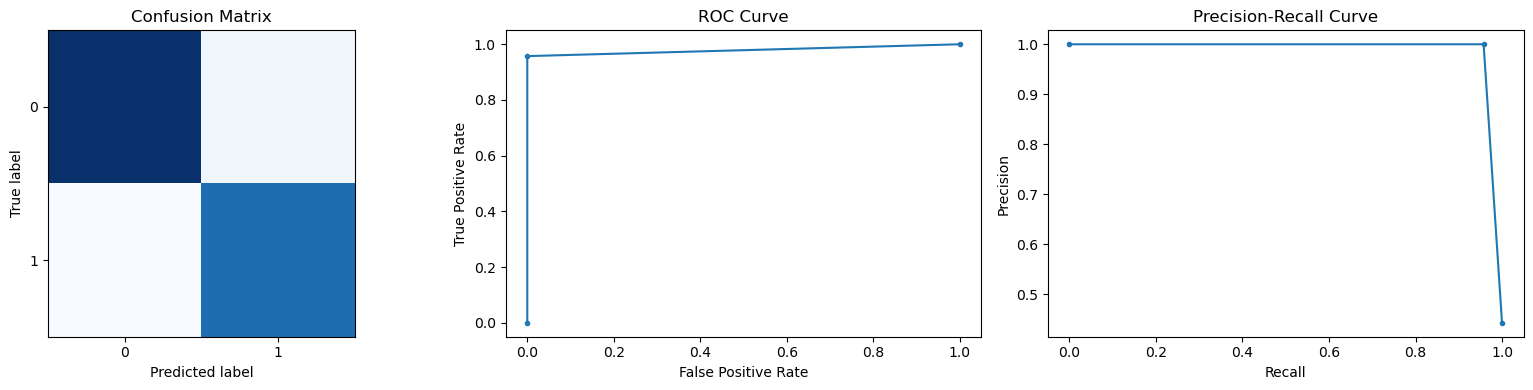

Accuracy: 1.0 
Precision: 1.0 
Recall: 1.0 
F1 Score: 1.0 
AUC: 1.0


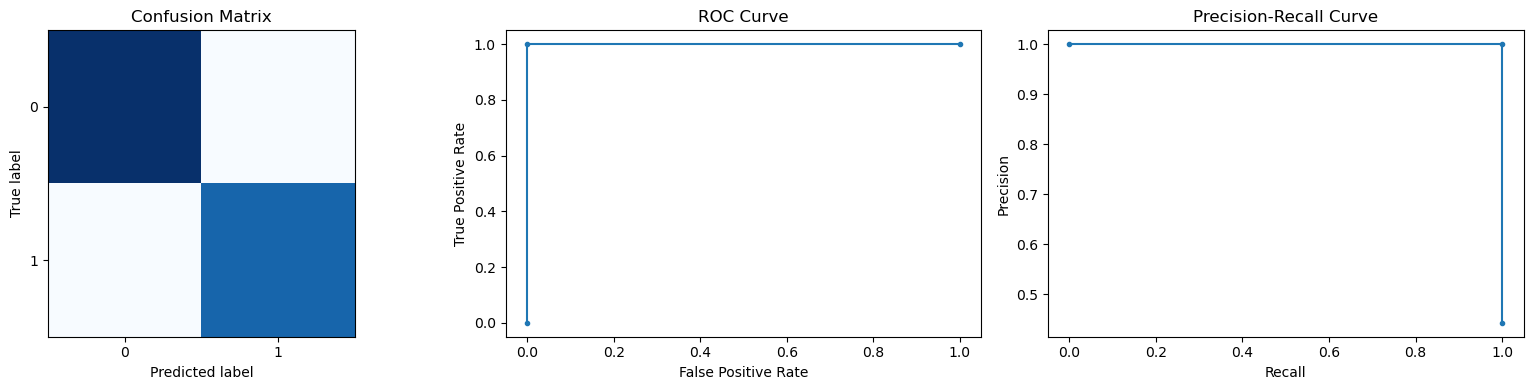

In [159]:
# Valutazione dell'albero di decisione

# Il mio modello

model_params = {"h_max": range(1, 21)}

optim_params["Desicion Tree"], classification_results["Desicion Tree"] = model_selection(MyDesicionTreeClassifier, model_params, bins=10, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

sklearn_results(model, "classification")

#### VIsualizzazione


In [160]:
def prepare_tree(tree, cols): # Prepara l'albero per la visualizzazione con printree
    copy = {}

    # controlla se l'albero è una foglia
    if type(tree) == int:
        return "> " + str(tree)

    # costruisce l'albero ricorsivamente
    key = list(tree.keys())[0]
    attr = cols[key]
    copy[attr] = {}
    for v in tree[key]:
        copy[attr][v] = prepare_tree(tree[key][v], cols)

    return copy

def print_tree(bins = 5, h_max = 5): # Stampa l'albero di decisione

    # codifica i dati
    e = Encoder('classification', bins=bins)
    x_train, y_train = e.fit_transform(dataset_training)

    # addestra l'albero di decisione
    model = MyDesicionTreeClassifier(h_max = h_max)
    model.fit(x_train, y_train)

    # ottiene le colonne del dataset
    columns = e.encoding(dataset_training).columns
    columns = [x for x in columns if x != 'NObeyesdad']

    # prepara l'albero per la visualizzazione
    tree = prepare_tree(model.tree, columns)

    # stampa l'albero
    print("Per ciascun attributo, il valore rappresenta il valore dell'attributo (in ordine di occorrenza) e il sottoalbero associato.")
    ptree(tree)

In [161]:
# Visualizzazione dell'albero di decisione con print_tree

print_tree(bins = 10, h_max = optim_params["Desicion Tree"]['h_max'])

Per ciascun attributo, il valore rappresenta il valore dell'attributo (in ordine di occorrenza) e il sottoalbero associato.
┐
└── Weight
    ├── 3
    │   └── Height
    │       ├── 4
    │       │   └── Age
    │       │       ├── 1
    │       │       │   └── TUE
    │       │       │       ├── 7: > 0
    │       │       │       ├── 4
    │       │       │       │   └── FCVC
    │       │       │       │       ├── 4: > 1
    │       │       │       │       ├── 8: > 0
    │       │       │       │       ├── 5: > 1
    │       │       │       │       └── 6: > 1
    │       │       │       ├── 8
    │       │       │       │   └── FCVC
    │       │       │       │       ├── 4: > 0
    │       │       │       │       └── 9: > 1
    │       │       │       ├── 5: > 0
    │       │       │       ├── 6: > 0
    │       │       │       ├── 0: > 0
    │       │       │       └── 1: > 0
    │       │       ├── 0
    │       │       │   └── FAVC
    │       │       │       ├── 1
    │       │ 

### Logistic Regression


La regressione logistica modella la probabilità che un esempio appartenga a una certa classe in funzione delle sue variabili di input.

La funzione sigmoide, definita come:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

è utilizzata per trasformare l'output del modello lineare in una probabilità compresa tra 0 e 1.

Il modello viene addestrato minimizzando la funzione di costo, che in questo caso è l'errore quadratico medio (MSE) con termini di regolarizzazione L1 e L2. La funzione di costo è definita come:

$$Loss(w) = \frac{1}{m}\sum_{i=1}^{m} (h_w(x^{(i)}) - y^{(i)})^2 + \lambda_1 ||w||_1 + \lambda_2 ||w||_2^2$$

dove $h_w(x^{(i)})$ è l'ipotesi del modello (la probabilità predetta che l'esempio $i$ appartenga alla classe positiva), $y^{(i)}$ è la classe reale dell'esempio $i$, $w$ sono i pesi del modello, e $\lambda_1$ e $\lambda_2$ sono i parametri di regolarizzazione.

L'addestramento del modello avviene attraverso l'algoritmo di discesa del gradiente, che aggiorna iterativamente i pesi del modello in direzione opposta al gradiente della funzione di costo. L'aggiornamento dei pesi è dato da:

$$w := w - \alpha \nabla_w Loss(w)$$

dove $\alpha$ è il tasso di apprendimento e $\nabla_w Loss(w)$ è il gradiente della funzione di costo rispetto ai pesi.

Infine, la funzione di previsione utilizza il modello addestrato per prevedere la classe di nuovi esempi. Se l'output del modello (la probabilità predetta) è maggiore di 0.5, l'esempio viene classificato come positivo, altrimenti viene classificato come negativo.

#### Implementazione


In [164]:
# Implementazione del modello di regressione logistica

class MyLogisticRegressor:

    def __init__(self, lambda1=0, lambda2=0, alpha=0.01, num_iterations=1000, cutoff=0.01, batch=-1):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha = alpha
        self.num_iterations = num_iterations
        self.cutoff = cutoff
        self.stocastic = batch != -1
        if self.stocastic:
            self.batch = batch

    def concat_ones(self, X):  # aggiunge una colonna di 1 per il termine noto
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    def sigmoid(self, z):  # funzione sigmoide

        # evita l'overflow
        z = np.clip(z, -500, 500)

        return 1 / (1 + np.exp(-z))

    def threshold(self, z):  # calcola la soglia per la classificazione
        return (z > 0.5).astype(int)

    def get_random_batch(self, X, Y): # Prende un batch casuale di dimensione batch
        indices = np.random.choice(np.arange(X.shape[0]), size=self.batch, replace=False)
        return X[indices], Y[indices]

    def gradient(self, x, y, verbose):  # calcola il gradiente

        # Se è stata specificata una dimensione del batch, prende un batch casuale
        if self.stocastic:
            x, y = self.get_random_batch(x, y)            

        y_pred = self.threshold(self.sigmoid(np.dot(self.w, x.T)))

        # Aggiungi l'errore alla lista per la visualizzazione
        if verbose:
            self.errori.append(mean_squared_error(y_pred, y))

        return np.dot((y - y_pred), x)

    def fit(self, X, Y, verbose=False):  # addestra il modello
        self.errori = []
        X = self.concat_ones(X)

        # inizializza i pesi con valori casuali
        self.w = np.zeros(X.shape[1])

        # addestra il modello
        for _ in range(self.num_iterations):
            prev_w = self.w.copy()

            # calcola il gradiente
            gradient = self.gradient(X, Y, verbose)

            # aggiorna i pesi
            self.w += self.alpha * (gradient + self.lambda1 * np.sign(self.w) + self.lambda2 * self.w)

            # controlla la convergenza
            max_diff = np.max(np.abs(self.w - prev_w))
            if max_diff < self.cutoff:
                break

        return self.errori

    def predict(self, X):  # predice i valori
        X = self.concat_ones(X)
        return self.threshold(self.sigmoid(np.dot(self.w, X.T)))

#### Classificazione


  >> Combo: (0, 0, 0.1, 100, 0.01) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 100, 0.001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 100, 0.0001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 1000, 0.01) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 1000, 0.001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 1000, 0.0001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 10000, 0.01) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 10000, 0.001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.1, 10000, 0.0001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.01, 100, 0.01) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.01, 100, 0.001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.01, 100, 0.0001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.01, 1000, 0.01) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.01, 1000, 0.001) >> Error: 0.005804749340369393
  >> Combo: (0, 0, 0.01, 1000, 0.0001) >> Error

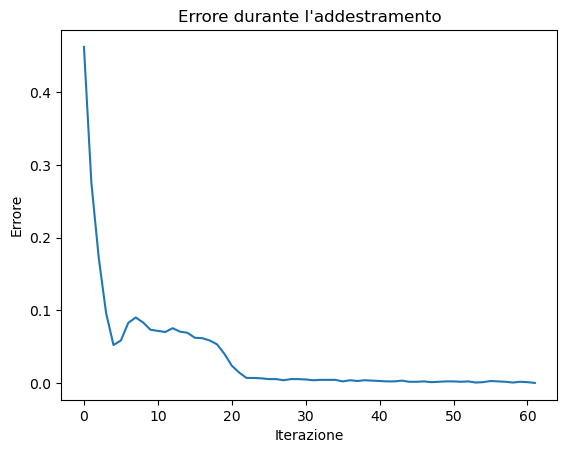

Accuracy: 1.0 
Precision: 1.0 
Recall: 1.0 
F1 Score: 1.0 
AUC: 1.0


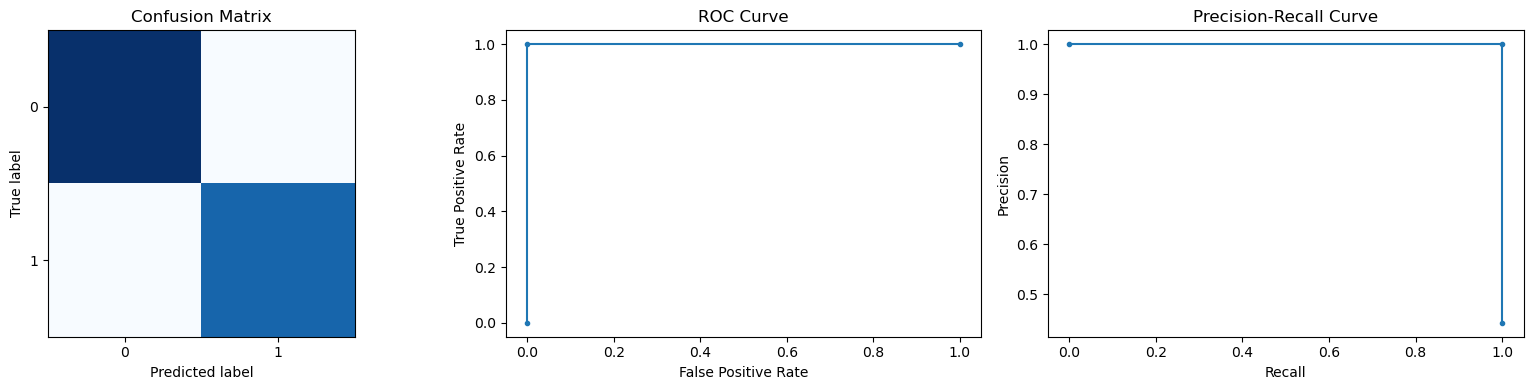

Accuracy: 0.9952830188679245 
Precision: 1.0 
Recall: 0.9894736842105263 
F1 Score: 0.9947089947089947 
AUC: 0.9947368421052631


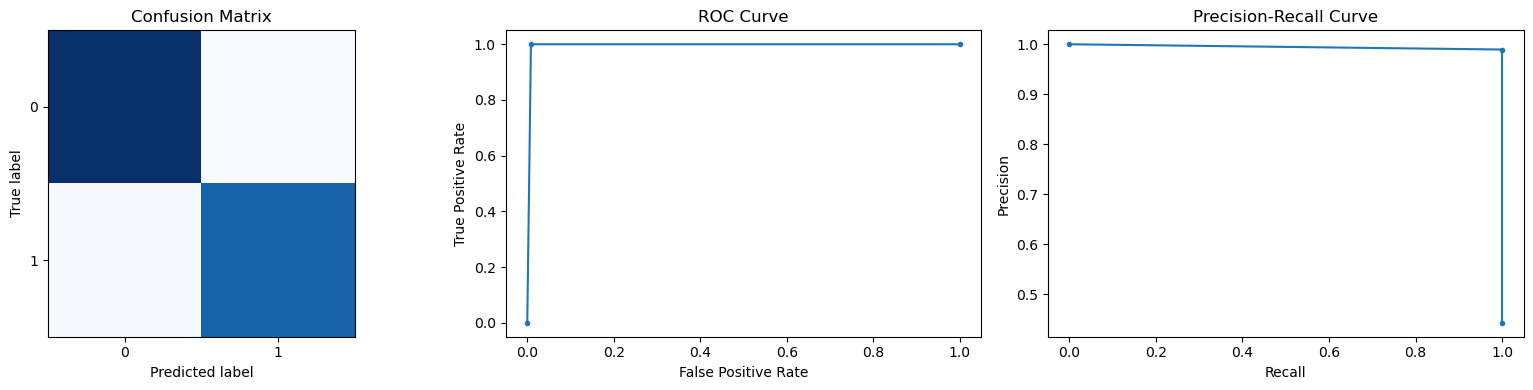

In [165]:
# Valutazione del modello di regressione logistica

# Il mio modello

model_params = {
    "lambda1": [0],
    "lambda2": [0],
    "alpha": [0.1, 0.01, 0.001],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.01, 0.001, 0.0001],
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="newton-cg")

sklearn_results(model, "classification", standardization=True)

  >> Combo: (0, 0, 0.1, 100, 0.001, 20) >> Error: 0.0949868073878628
  >> Combo: (0, 0, 0.1, 100, 0.001, 50) >> Error: 0.045910290237467025
  >> Combo: (0, 0, 0.1, 100, 0.001, 100) >> Error: 0.021108179419525065
  >> Combo: (0, 0, 0.1, 100, 0.0001, 20) >> Error: 0.07810026385224275
  >> Combo: (0, 0, 0.1, 100, 0.0001, 50) >> Error: 0.059102902374670176
  >> Combo: (0, 0, 0.1, 100, 0.0001, 100) >> Error: 0.0158311345646438
  >> Combo: (0, 0, 0.1, 100, 1e-05, 20) >> Error: 0.1171503957783641
  >> Combo: (0, 0, 0.1, 100, 1e-05, 50) >> Error: 0.02163588390501319
  >> Combo: (0, 0, 0.1, 100, 1e-05, 100) >> Error: 0.024274406332453823
  >> Combo: (0, 0, 0.1, 1000, 0.001, 20) >> Error: 0.07071240105540896
  >> Combo: (0, 0, 0.1, 1000, 0.001, 50) >> Error: 0.04063324538258575
  >> Combo: (0, 0, 0.1, 1000, 0.001, 100) >> Error: 0.017941952506596307
  >> Combo: (0, 0, 0.1, 1000, 0.0001, 20) >> Error: 0.10131926121372033
  >> Combo: (0, 0, 0.1, 1000, 0.0001, 50) >> Error: 0.039050131926121376
  >

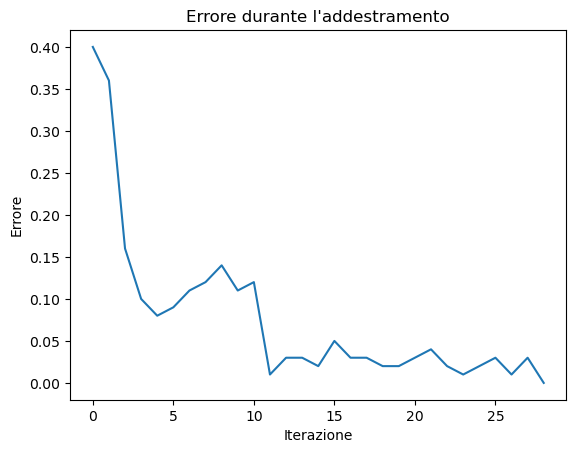

Accuracy: 0.9669811320754716 
Precision: 0.9893617021276596 
Recall: 0.9393939393939394 
F1 Score: 0.9637305699481866 
AUC: 0.9652721909359078


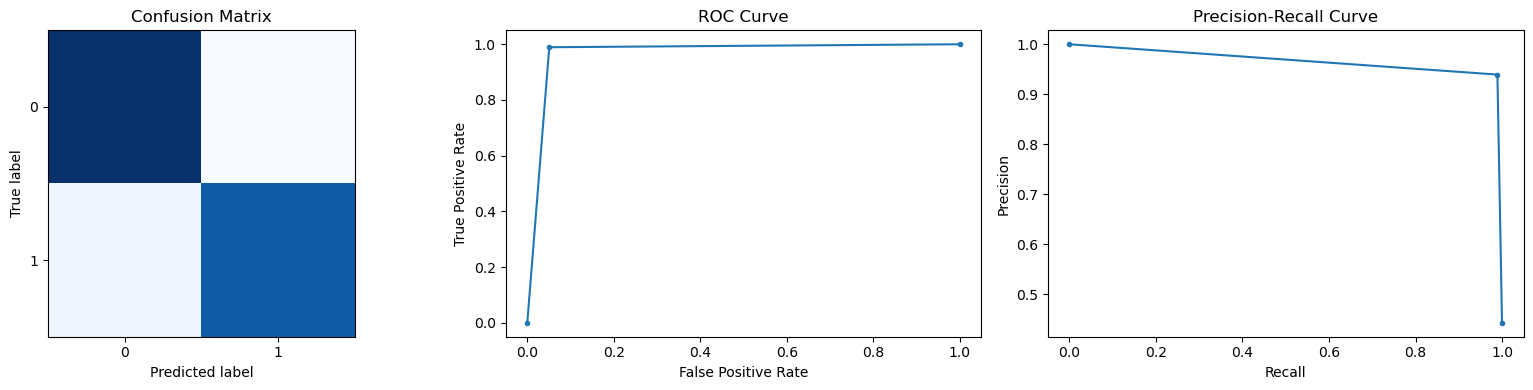

Accuracy: 0.9952830188679245 
Precision: 1.0 
Recall: 0.9894736842105263 
F1 Score: 0.9947089947089947 
AUC: 0.9947368421052631


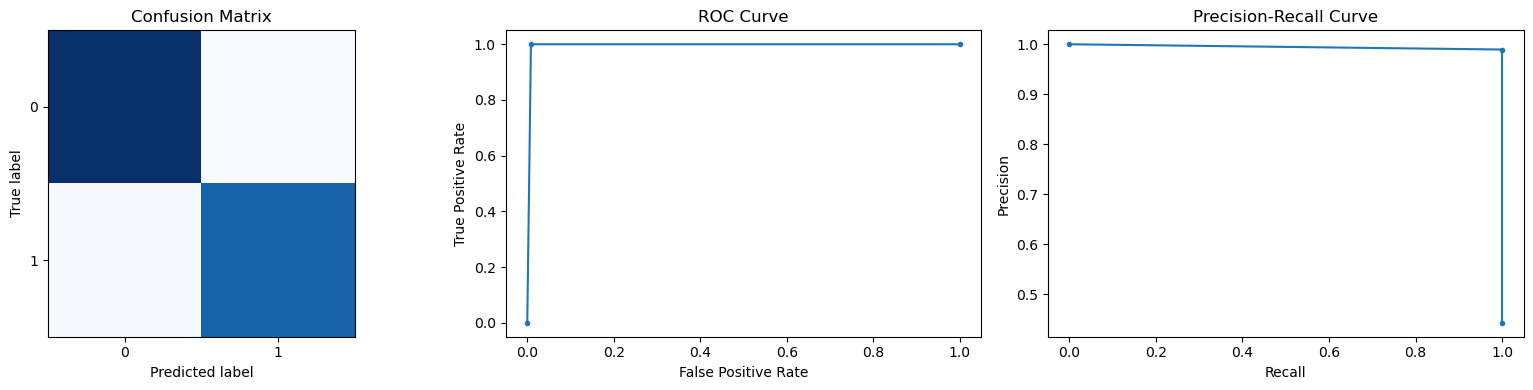

In [168]:
# Valutazione del modello di regressione logistica stocastica

# Il mio modello

model_params = {
    "lambda1": [0],
    "lambda2": [0],
    "alpha": [0.1, 0.01, 0.001],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.001, 0.0001, 0.00001],
    "batch": [20, 50, 100],
}

optim_params["Logistic Regression SGD"], classification_results["Logistic Regression SGD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression SGD"]["num_iterations"]
tol = optim_params["Logistic Regression SGD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="sag")

sklearn_results(model, "classification", standardization=True)

##### Regolarizzazione


  >> Combo: (0.1, 0, 0.1, 100, 0.01, 20) >> Error: 0.046437994722955137
  >> Combo: (0.1, 0, 0.1, 100, 0.01, 50) >> Error: 0.020052770448548814
  >> Combo: (0.1, 0, 0.1, 100, 0.01, 100) >> Error: 0.017941952506596307
  >> Combo: (0.1, 0, 0.1, 100, 0.001, 20) >> Error: 0.03430079155672823
  >> Combo: (0.1, 0, 0.1, 100, 0.001, 50) >> Error: 0.022691292875989443
  >> Combo: (0.1, 0, 0.1, 100, 0.001, 100) >> Error: 0.013720316622691292
  >> Combo: (0.1, 0, 0.1, 100, 0.0001, 20) >> Error: 0.048548812664907647
  >> Combo: (0.1, 0, 0.1, 100, 0.0001, 50) >> Error: 0.02532981530343008
  >> Combo: (0.1, 0, 0.1, 100, 0.0001, 100) >> Error: 0.016886543535620056
  >> Combo: (0.1, 0, 0.1, 1000, 0.01, 20) >> Error: 0.024802110817941952
  >> Combo: (0.1, 0, 0.1, 1000, 0.01, 50) >> Error: 0.018997361477572562
  >> Combo: (0.1, 0, 0.1, 1000, 0.01, 100) >> Error: 0.01266490765171504
  >> Combo: (0.1, 0, 0.1, 1000, 0.001, 20) >> Error: 0.02321899736147757
  >> Combo: (0.1, 0, 0.1, 1000, 0.001, 50) >> Erro

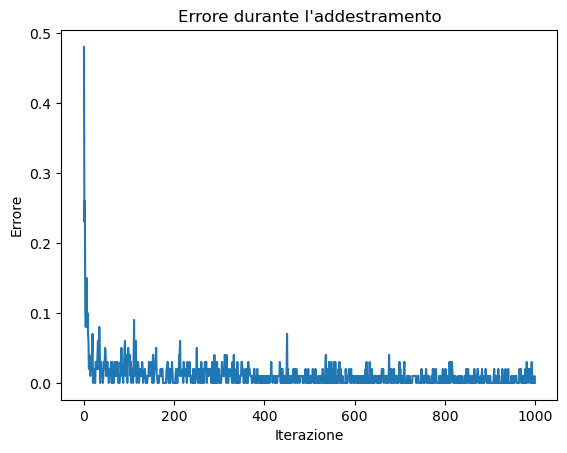

Accuracy: 0.9905660377358491 
Precision: 0.9787234042553191 
Recall: 1.0 
F1 Score: 0.989247311827957 
AUC: 0.9916666666666666


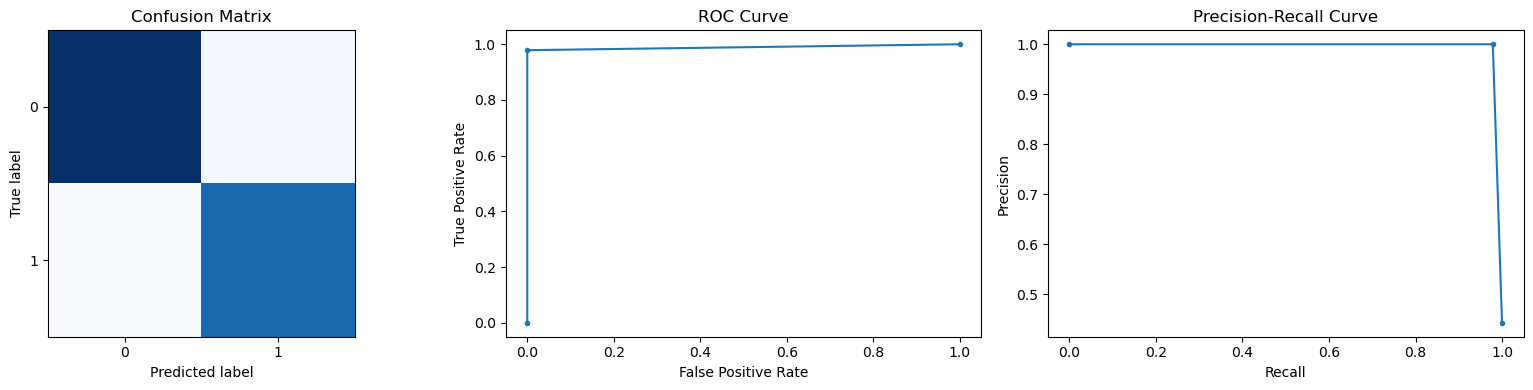

Accuracy: 1.0 
Precision: 1.0 
Recall: 1.0 
F1 Score: 1.0 
AUC: 1.0


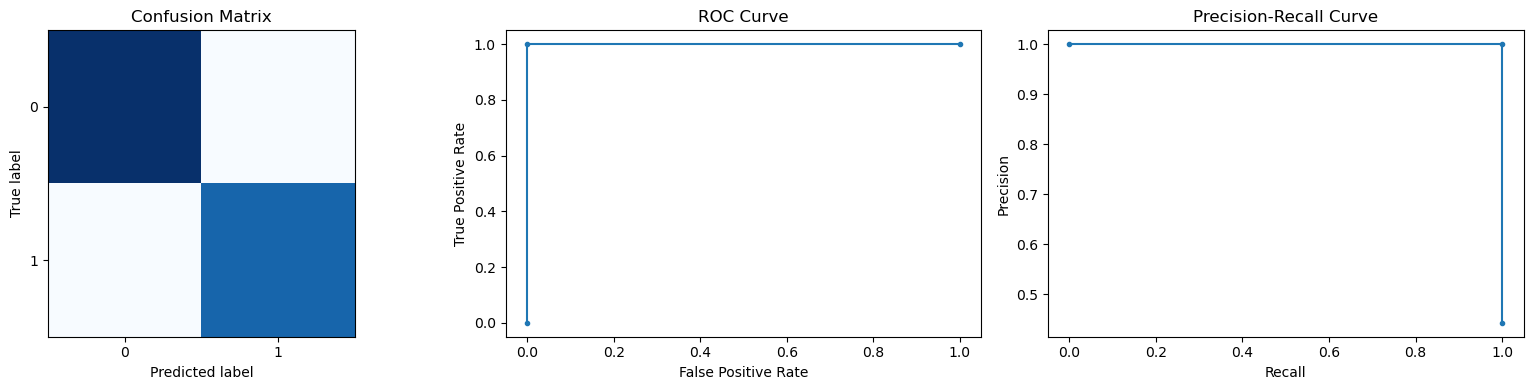

In [169]:
# Valutazione del modello di regressione logistica stocastica con regolarizzazione L1

model_params = {
    "lambda1": [0.1],
    "lambda2": [0],
    "alpha": [0.1, 0.01, 0.001],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.01, 0.001, 0.0001],
    "batch": [20, 50, 100],
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="saga", penalty="l1")

sklearn_results(model, "classification", standardization=True)

  >> Combo: (0, 0.1, 0.1, 100, 0.01, 20) >> Error: 0.02321899736147757
  >> Combo: (0, 0.1, 0.1, 100, 0.01, 50) >> Error: 0.013192612137203167
  >> Combo: (0, 0.1, 0.1, 100, 0.01, 100) >> Error: 0.0079155672823219
  >> Combo: (0, 0.1, 0.1, 100, 0.001, 20) >> Error: 0.022163588390501317
  >> Combo: (0, 0.1, 0.1, 100, 0.001, 50) >> Error: 0.015831134564643797
  >> Combo: (0, 0.1, 0.1, 100, 0.001, 100) >> Error: 0.007387862796833773
  >> Combo: (0, 0.1, 0.1, 100, 0.0001, 20) >> Error: 0.024802110817941952
  >> Combo: (0, 0.1, 0.1, 100, 0.0001, 50) >> Error: 0.008970976253298154
  >> Combo: (0, 0.1, 0.1, 100, 0.0001, 100) >> Error: 0.006860158311345646
  >> Combo: (0, 0.1, 0.1, 1000, 0.01, 20) >> Error: 0.004221635883905013
  >> Combo: (0, 0.1, 0.1, 1000, 0.01, 50) >> Error: 0.0036939313984168864
  >> Combo: (0, 0.1, 0.1, 1000, 0.01, 100) >> Error: 0.004221635883905013
  >> Combo: (0, 0.1, 0.1, 1000, 0.001, 20) >> Error: 0.010026385224274407
  >> Combo: (0, 0.1, 0.1, 1000, 0.001, 50) >> Er

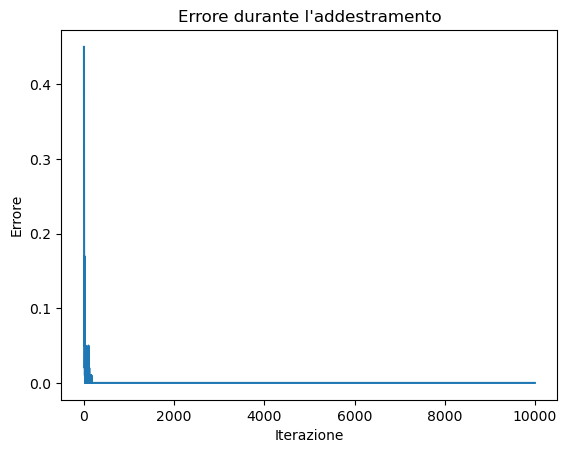

Accuracy: 0.9952830188679245 
Precision: 1.0 
Recall: 0.9894736842105263 
F1 Score: 0.9947089947089947 
AUC: 0.9947368421052631


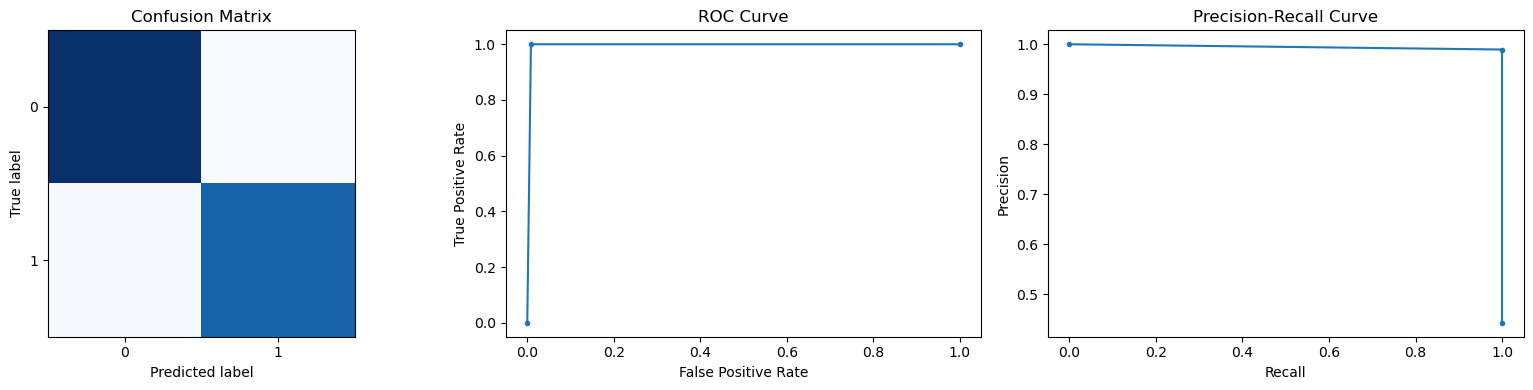

Accuracy: 0.9858490566037735 
Precision: 0.9893617021276596 
Recall: 0.9789473684210527 
F1 Score: 0.9841269841269842 
AUC: 0.985200179937022


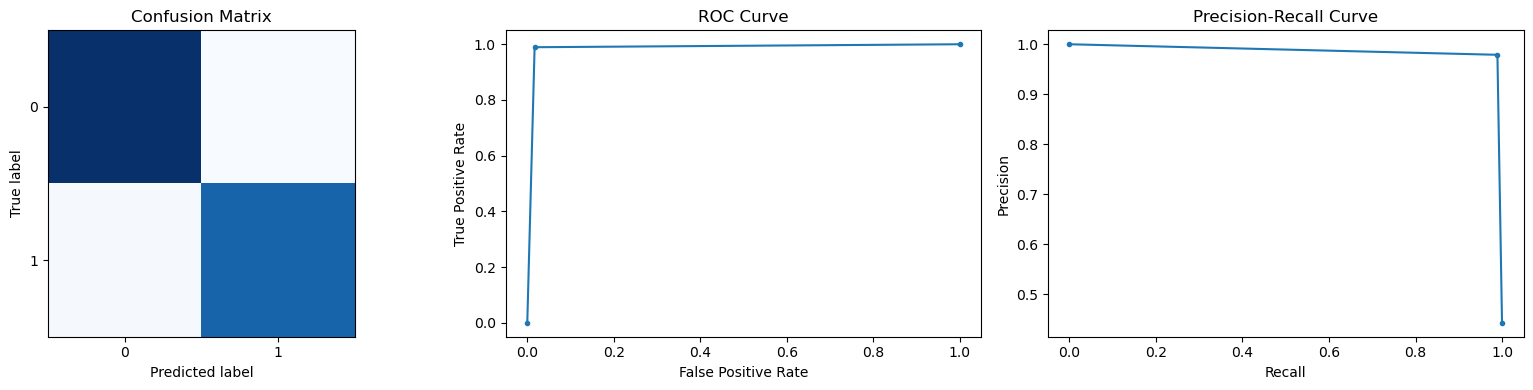

In [171]:
# Valutazione del modello di regressione logistica stocastica con regolarizzazione L2

model_params = {
    "lambda1": [0],
    "lambda2": [0.1],
    "alpha": [0.1, 0.01, 0.001],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.01, 0.001, 0.0001],
    "batch": [20, 50, 100],
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="saga", penalty="l2")

sklearn_results(model, "classification", standardization=True)

  >> Combo: (0.1, 0.1, 0.1, 100, 0.01, 20) >> Error: 0.03535620052770448
  >> Combo: (0.1, 0.1, 0.1, 100, 0.01, 50) >> Error: 0.02058047493403694
  >> Combo: (0.1, 0.1, 0.1, 100, 0.01, 100) >> Error: 0.011609498680738786
  >> Combo: (0.1, 0.1, 0.1, 100, 0.001, 20) >> Error: 0.034828496042216356
  >> Combo: (0.1, 0.1, 0.1, 100, 0.001, 50) >> Error: 0.013192612137203167
  >> Combo: (0.1, 0.1, 0.1, 100, 0.001, 100) >> Error: 0.012664907651715037
  >> Combo: (0.1, 0.1, 0.1, 100, 0.0001, 20) >> Error: 0.029023746701846966
  >> Combo: (0.1, 0.1, 0.1, 100, 0.0001, 50) >> Error: 0.022691292875989446
  >> Combo: (0.1, 0.1, 0.1, 100, 0.0001, 100) >> Error: 0.012137203166226913
  >> Combo: (0.1, 0.1, 0.1, 1000, 0.01, 20) >> Error: 0.021108179419525065
  >> Combo: (0.1, 0.1, 0.1, 1000, 0.01, 50) >> Error: 0.015831134564643797
  >> Combo: (0.1, 0.1, 0.1, 1000, 0.01, 100) >> Error: 0.013720316622691292
  >> Combo: (0.1, 0.1, 0.1, 1000, 0.001, 20) >> Error: 0.024274406332453827
  >> Combo: (0.1, 0.1,

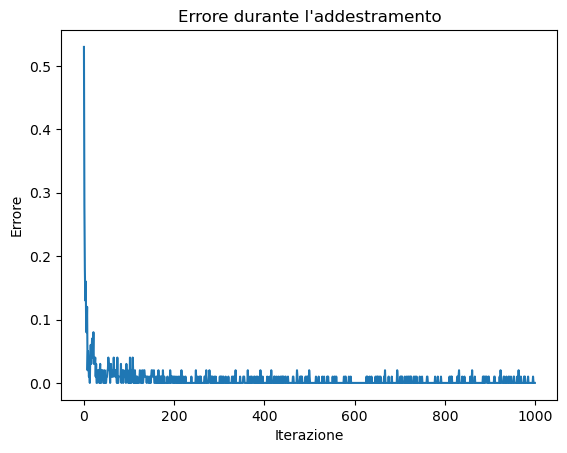

Accuracy: 0.9952830188679245 
Precision: 0.9893617021276596 
Recall: 1.0 
F1 Score: 0.9946524064171123 
AUC: 0.9957983193277311


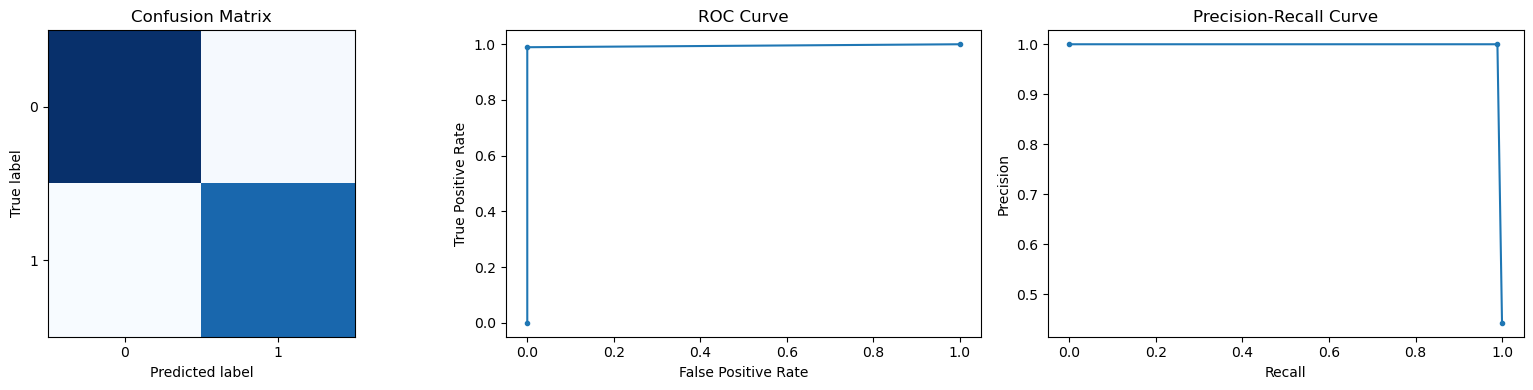

Accuracy: 0.9952830188679245 
Precision: 1.0 
Recall: 0.9894736842105263 
F1 Score: 0.9947089947089947 
AUC: 0.9947368421052631


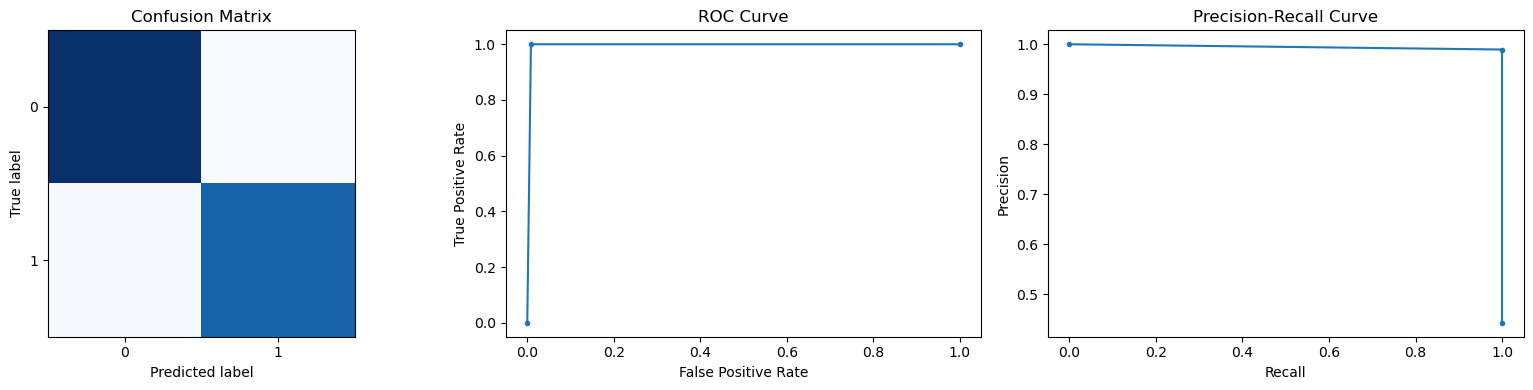

In [172]:
# Valutazione del modello di regressione logistica stocastica con regolarizzazione L1 + L2

model_params = {
    "lambda1": [0.1],
    "lambda2": [0.1],
    "alpha": [0.1, 0.01, 0.001],
    "num_iterations": [100, 1000, 10000],
    "cutoff": [0.01, 0.001, 0.0001],
    "batch": [20, 50, 100],
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]
li_ratio = optim_params["Logistic Regression GD"]["lambda1"] / optim_params["Logistic Regression GD"]["lambda1"] + optim_params["Logistic Regression GD"]["lambda2"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="saga", penalty="elasticnet", l1_ratio=l1_ratio)

sklearn_results(model, "classification", standardization=True)

### K-Nearest-Neighbor


Il modello K-Nearest Neighbors (KNN) prevede la classe o il valore di un esempio in base alle classi o ai valori dei suoi "vicini" più prossimi.

La distanza tra due esempi viene calcolata utilizzando la distanza di Minkowski, definita come:

$$D(x, y) = \left(\sum_{i=1}^{n} |x_i - y_i|^p\right)^{1/p}$$

dove $x$ e $y$ sono due esempi, $n$ è il numero di variabili di input, e $p$ è un parametro che determina il tipo di distanza (per esempio, $p=2$ corrisponde alla distanza euclidea).

L'algoritmo trova i $k$ esempi più vicini a un esempio dato, e fa una previsione basata su di essi. Se il modello è in modalità di classificazione, la previsione è la classe più comune tra i vicini. Se il modello è in modalità di regressione, la previsione è la media dei valori dei vicini.

La funzione `fit` salva i dati di addestramento, che vengono poi utilizzati per trovare i vicini durante la previsione. La funzione `predict` applica l'algoritmo K-NN a un set di esempi per fare le previsioni.

#### Implementazione


In [173]:
# Implementazione del modello K-Nearest Neighbors

class MyNearestNeighbors:

    def __init__(self, mode, method = None, k=3, p=2): # Inizializza il modello
        self.k = k
        self.p = p
        self.mode = mode

    def fit(self, X, Y, verbose=False): # Salva i dati di addestramento
        self.X = X
        self.Y = Y

    def minkowski_distance(self, x1, x2, p): # Calcola la distanza di Minkowski
        return np.sum(np.abs(x1 - x2) ** p, axis=1) ** (1 / p)

    def NN(self, x): # Trova gli indici dei k vicini
        distances = self.minkowski_distance(x, self.X, self.p)
        indices = np.argsort(distances)[:self.k]
        return indices

    def kernel(self, d): # Calcola il kernel quadratico
        return np.maximum(0, 1 - (2 * d / self.w) ** 2)

    def classify(self, indices): # Discretizza i valori per la classificazione
        return np.round(np.mean(self.Y[indices], axis=1)).astype(int)

    def average(self, indices): # Calcola la media dei valori per la regressione
        return np.mean(self.Y[indices], axis=1)

    def predict(self, X): # Predice i valori in base alla modalità
        indices = np.apply_along_axis(self.NN, 1, X)
        if self.mode == "classification":
            return self.classify(indices)
        if self.mode == "regression":
            return self.average(indices)

#### Regressione


meglio senza standardizzazione


In [174]:
# Valutazione del modello KNN per la regressione

# Il mio modello

model_params = {
    "mode": ["regression"],
    "k": [3, 5, 7],
    "p": [1, 2, 3],
}

print("Metriche per il KNN Regression")
optim_params["KNN Regression"], regression_results["KNN Regression"] = model_selection(MyNearestNeighbors, model_params, mode="regression", verbose=True)

# Il modello di sklearn

from sklearn.neighbors import KNeighborsRegressor

n_neighbors = optim_params["KNN Regression"]["k"]
p = optim_params["KNN Regression"]["p"]
weights = "uniform"

model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p, weights=weights)

print("\nMetriche per il KNN Regression di sklearn")
sklearn_results(model, "regression")

Metriche per il KNN Regression
  >> Combo: ('regression', 3, 1) >> Error: 39.55883795284431
  >> Combo: ('regression', 3, 2) >> Error: 34.4496535525691
  >> Combo: ('regression', 3, 3) >> Error: 34.14534899467648
  >> Combo: ('regression', 5, 1) >> Error: 39.55883795284431
  >> Combo: ('regression', 5, 2) >> Error: 34.4496535525691
  >> Combo: ('regression', 5, 3) >> Error: 34.14534899467648
  >> Combo: ('regression', 7, 1) >> Error: 39.55883795284431
  >> Combo: ('regression', 7, 2) >> Error: 34.4496535525691
  >> Combo: ('regression', 7, 3) >> Error: 34.14534899467648
  => Optimal combo: ('regression', 3, 3) >>
MSE: 32.94137834824233 
MAE: 3.0451824858490575 
RMSE: 5.739458018684545

Metriche per il KNN Regression di sklearn
MSE: 34.672909743797725 
MAE: 3.200379584905661 
RMSE: 5.88837072064911


#### Classificazione


Metriche per il KNN Classification
  >> Combo: ('classification', 3, 1) >> Error: 0.020052770448548814
  >> Combo: ('classification', 3, 2) >> Error: 0.018997361477572562
  >> Combo: ('classification', 3, 3) >> Error: 0.024274406332453823
  >> Combo: ('classification', 5, 1) >> Error: 0.020052770448548814
  >> Combo: ('classification', 5, 2) >> Error: 0.018997361477572562
  >> Combo: ('classification', 5, 3) >> Error: 0.024274406332453823
  >> Combo: ('classification', 7, 1) >> Error: 0.020052770448548814
  >> Combo: ('classification', 7, 2) >> Error: 0.018997361477572562
  >> Combo: ('classification', 7, 3) >> Error: 0.024274406332453823
  => Optimal combo: ('classification', 3, 2) >>
Accuracy: 0.9905660377358491 
Precision: 1.0 
Recall: 0.9791666666666666 
F1 Score: 0.9894736842105264 
AUC: 0.9895833333333333


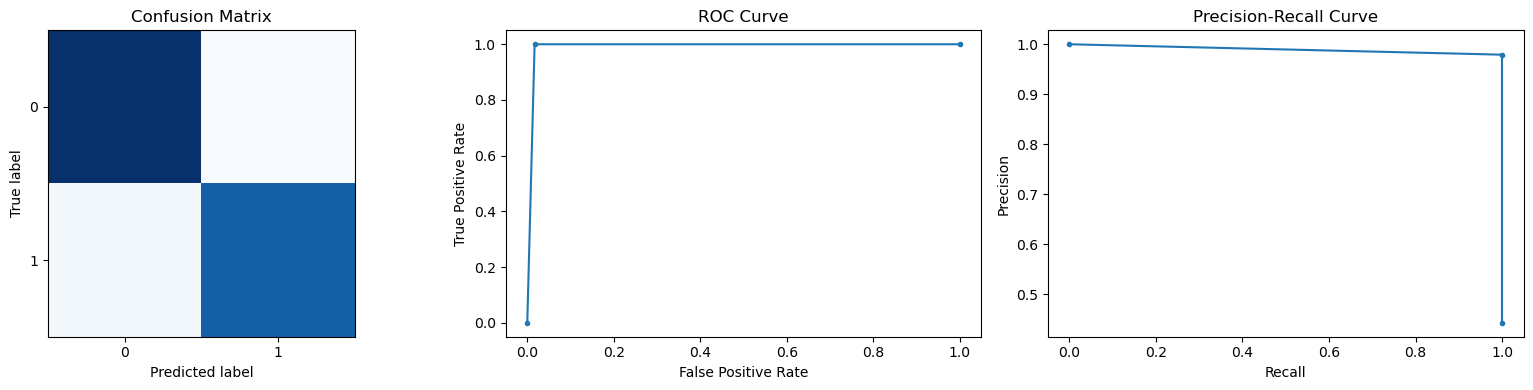


Metriche per il KNN Classification di sklearn
Accuracy: 0.9858490566037735 
Precision: 1.0 
Recall: 0.9690721649484536 
F1 Score: 0.9842931937172774 
AUC: 0.9845360824742269


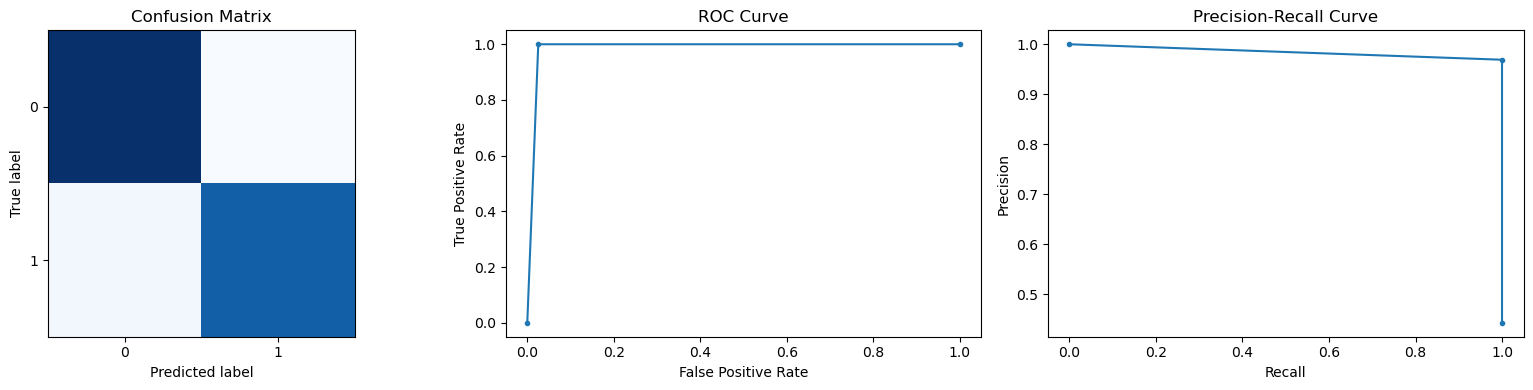

In [175]:
# Valutazione del modello KNN per la classificazione

# Il mio modello

model_params = {
    "mode": ["classification"],
    "k": [3, 5, 7],
    "p": [1, 2, 3],
}

print("Metriche per il KNN Classification")
optim_params["KNN Classification"], classification_results["KNN Classification"] = model_selection(MyNearestNeighbors, model_params, mode="classification", verbose=True)

# Il modello di sklearn

from sklearn.neighbors import KNeighborsClassifier

n_neighbors = optim_params["KNN Classification"]["k"]
p = optim_params["KNN Classification"]["p"]
weights = "uniform"

model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights)

print("\nMetriche per il KNN Classification di sklearn")
sklearn_results(model, "classification")

### Neural Network


La seguente classe implementa una rete neurale composta da neuroni organizzati in strati, e ogni neurone in uno strato è connesso a tutti i neuroni nello strato successivo.

La funzione `initialize_parameters` inizializza i pesi e i bias di ogni connessione, inizializzati con valori casuali.

La funzione `sigmoid` implementa la funzione sigmoide, definita come:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

La funzione `relu` implementa la funzione ReLU (Rectified Linear Unit), definita come:

$$\text{ReLU}(x) = \max(0, x)$$

La funzione `forward_propagation` implementa la propagazione in avanti, che calcola l'output della rete neurale per un dato input. Per ogni strato, l'output viene calcolato come il prodotto scalare tra l'input e i pesi, sommato al bias, e poi passato attraverso la funzione di attivazione.

La funzione `backpropagation` implementa la propagazione all'indietro, che aggiorna i pesi e i bias in base all'errore tra l'output previsto e quello effettivo. L'errore viene propagato all'indietro dalla fine alla partenza della rete, e i pesi e i bias vengono aggiornati in modo proporzionale al gradiente dell'errore rispetto a loro.

La funzione `fit` addestra la rete neurale, eseguendo la propagazione in avanti e all'indietro per un numero specificato di epoche.

La funzione `predict` calcola l'output della rete neurale per un dato input. Se la rete è in modalità di classificazione, l'output viene discretizzato a 0 o 1 utilizzando una soglia di 0.5.

#### Implementazione


In [178]:
class MyNeuralNetwork:

    def __init__(self, mode, hidden_layer_sizes, n_epochs=1000, learning_rate=0.01): # Inizializza il modello
        assert mode in ["classification", "regression"]
        self.hidden_layer_sizes = [eval(i) for i in hidden_layer_sizes.split("-")]
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.mode = mode

        # Imposta la funzione di attivazione in base alla modalità
        self.activation_function = self.sigmoid if mode == "classification" else self.relu
        self.activation_function_derivative = self.sigmoid_derivative if mode == "classification" else self.relu_derivative

    def initialize_parameters(self, X): # Inizializza i pesi e i bias
        self.weights = []
        self.biases = []

        # Per ogni layer
        for i in range(len(self.hidden_layer_sizes) + 1):

            # Calcola il numero di neuroni di input e output
            if i == 0:
                n_input_neurons = X.shape[1]
            else:
                n_input_neurons = self.hidden_layer_sizes[i - 1]
            if i == len(self.hidden_layer_sizes):
                n_output_neurons = 1
            else:
                n_output_neurons = self.hidden_layer_sizes[i]

            # Inizializza i pesi e i bias con valori casuali
            self.weights.append(np.random.rand(n_input_neurons, n_output_neurons))
            self.biases.append(np.random.rand(n_output_neurons))

    def sigmoid(self, x): # Funzione sigmoide
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, y): # Derivata della funzione sigmoide
        return y * (1 - y)

    def relu(self, x): # Funzione ReLU
        return np.maximum(0, x)

    def relu_derivative(self, y): # Derivata della funzione ReLU
        return (y > 0).astype(int)

    def forward_propagation(self, X): # Propagazione in avanti

        # Inizializza l'output con i dati di input
        a = X
        self.outputs = [a]

        # Per ogni layer
        for i in range(len(self.weights)):

            # Calcola l'output
            z = np.dot(a, self.weights[i]) + self.biases[i]
            z = self.activation_function(z)
            a = z

            # Salva l'output
            self.outputs.append(a)

        return a

    def backpropagation(self, y, a): # Propagazione all'indietro

        # Inizializza i gradienti
        grad_weights = [np.zeros_like(w) for w in self.weights]
        grad_biases = [np.zeros_like(b) for b in self.biases]

        # Inizializza l'errore
        delta = a - y.reshape(-1, 1)

        # Per ogni layer
        for i in reversed(range(len(self.weights))):

            # Calcola il gradiente
            delta = delta * self.activation_function_derivative(self.outputs[i+1])

            # Aggiorna i pesi e i bias
            grad_weights[i] = np.dot(self.outputs[i].T, delta)
            grad_biases[i] = np.mean(delta, axis=0)

            # Calcola l'errore per il layer precedente
            delta = np.dot(delta, self.weights[i].T)

        return grad_weights, grad_biases

    def fit(self, X, y, verbose=False): # Addestra il modello
        self.errori = []

        # Inizializza i pesi e i bias
        self.initialize_parameters(X)

        # Per ogni epoca
        for _ in range(self.n_epochs):

            # Propagazione in avanti
            a = self.forward_propagation(X)

            # Aggiungi l'errore alla lista per la visualizzazione
            if verbose:
                self.errori.append(mean_squared_error(a, y))

            # Propagazione all'indietro
            grad_weights, grad_biases = self.backpropagation(y, a)

            # Aggiorna i pesi e i bias
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grad_weights[i]
                self.biases[i] -= self.learning_rate * grad_biases[i]

        return self.errori

    def predict(self, X): # Predice i valori
        a = self.forward_propagation(X).reshape(-1)
        if self.mode == "classification":
            a = (a > 0.5).astype(int)
        return a

#### Regression


funziona solo per learning rate = 1.e-6

Metriche per la Neural Network Regression
  >> Combo: ('regression', '10-10', 100, 1e-06) >> Error: 65.10504711353484
  >> Combo: ('regression', '10-10', 100, 1e-08) >> Error: 3150.5571293024655
  >> Combo: ('regression', '10-10', 100, 1e-10) >> Error: 3898.809278378341
  >> Combo: ('regression', '10-10', 1000, 1e-06) >> Error: 25.016817560186933
  >> Combo: ('regression', '10-10', 1000, 1e-08) >> Error: 1200.1936211097413
  >> Combo: ('regression', '10-10', 1000, 1e-10) >> Error: 4166.545650320776
  >> Combo: ('regression', '10-10', 10000, 1e-06) >> Error: 20.39048724138018
  >> Combo: ('regression', '10-10', 10000, 1e-08) >> Error: 78.78616340759315
  >> Combo: ('regression', '10-10', 10000, 1e-10) >> Error: 3433.418671896681
  >> Combo: ('regression', '20-20', 100, 1e-06) >> Error: 8173.238929098743
  >> Combo: ('regression', '20-20', 100, 1e-08) >> Error: 3408.271332304742
  >> Combo: ('regression', '20-20', 100, 1e-10) >> Error: 19481.994108044466
  >> Combo: ('regression', '20-20

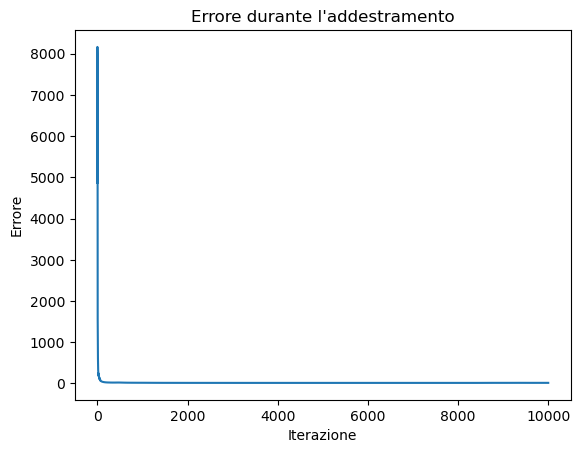

MSE: 18.353535930425625 
MAE: 3.2424099390858268 
RMSE: 4.284102698398537

Metriche per la Neural Network Regression di sklearn
MSE: 19.026149160881317 
MAE: 3.195789249056704 
RMSE: 4.361897426680425


In [179]:
# Valutazione del modello di rete neurale per la regressione

# Il mio modello

model_params = {
    "mode": ["regression"],
    "hidden_layer_sizes": ["10-10", "20-20", "30-30"],
    "n_epochs": [100, 1000, 10000],
    "learning_rate": [1.e-6, 1.e-8, 1.e-10],
}

print("Metriche per la Neural Network Regression")
optim_params["Neural Network Regression"], regression_results["Neural Network Regression"] = model_selection(MyNeuralNetwork, model_params, mode="regression", standardization=True, verbose=True)


# Il modello di sklearn

from sklearn.neural_network import MLPRegressor

hidden_layer_sizes = list(map(int, optim_params["Neural Network Regression"]["hidden_layer_sizes"].split("-")))
n_epochs = optim_params["Neural Network Regression"]["n_epochs"]

model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=n_epochs, activation="relu")

print("\nMetriche per la Neural Network Regression di sklearn")
sklearn_results(model, "regression", standardization=True)


#### Classification


Metriche per la Neural Network
  >> Combo: ('classification', '10-10', 100, 0.01) >> Error: 0.2955145118733509
  >> Combo: ('classification', '10-10', 100, 0.001) >> Error: 0.5398416886543536
  >> Combo: ('classification', '10-10', 100, 0.0001) >> Error: 0.537203166226913
  >> Combo: ('classification', '10-10', 1000, 0.01) >> Error: 0.006332453825857519
  >> Combo: ('classification', '10-10', 1000, 0.001) >> Error: 0.010554089709762533
  >> Combo: ('classification', '10-10', 1000, 0.0001) >> Error: 0.5266490765171505
  >> Combo: ('classification', '10-10', 10000, 0.01) >> Error: 0.003693931398416886
  >> Combo: ('classification', '10-10', 10000, 0.001) >> Error: 0.00474934036939314
  >> Combo: ('classification', '10-10', 10000, 0.0001) >> Error: 0.013192612137203167
  >> Combo: ('classification', '20-20', 100, 0.01) >> Error: 0.4912928759894458
  >> Combo: ('classification', '20-20', 100, 0.001) >> Error: 0.537203166226913
  >> Combo: ('classification', '20-20', 100, 0.0001) >> Error: 

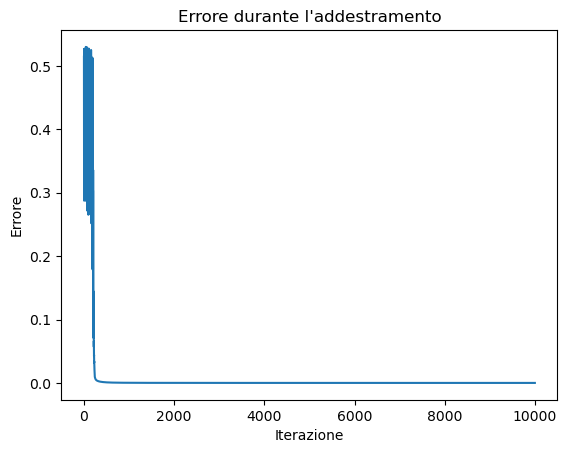

Accuracy: 0.9905660377358491 
Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
F1 Score: 0.9893617021276596 
AUC: 0.9904435629282367


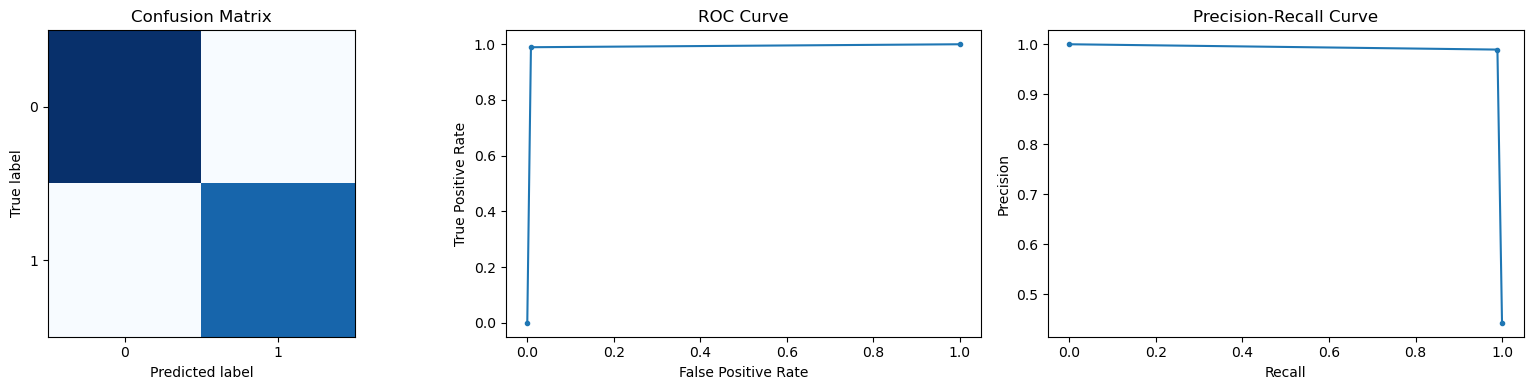

Accuracy: 0.9905660377358491 
Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
F1 Score: 0.9893617021276596 
AUC: 0.9904435629282367


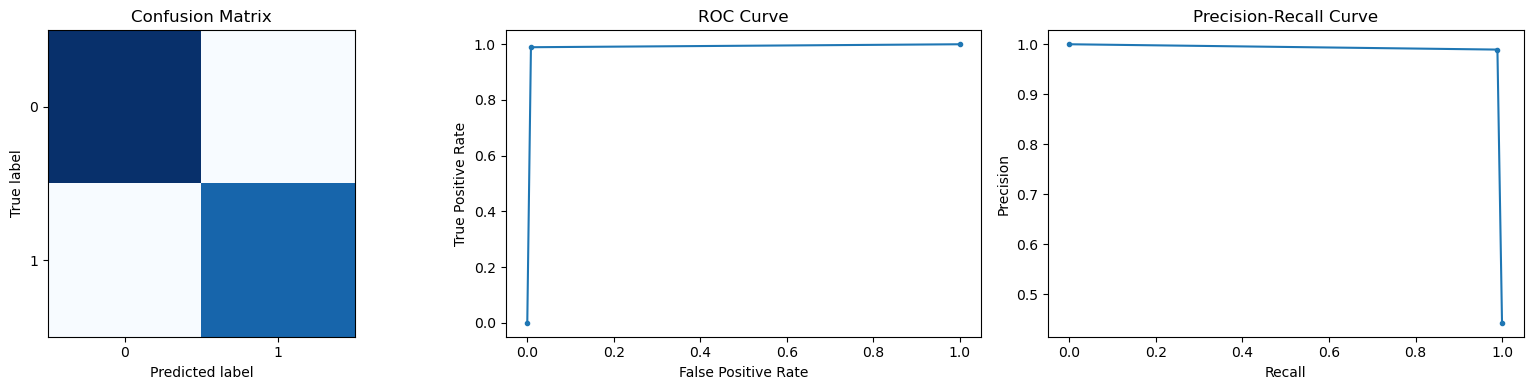

In [180]:
# Valutazione del modello Neural Network per la classificazione

# Il mio modello

model_params = {
    "mode": ["classification"],
    "layers": ["10-10", "20-20", "30-30"],
    "epochs": [100, 1000, 10000],
    "learning_rate": [0.01, 0.001, 0.0001],
}

print("Metriche per la Neural Network") 
optim_params["Neural Network Classification"], classification_results["Neural Network Classification"] = model_selection(MyNeuralNetwork, model_params, mode="classification", standardization=True, verbose=True)

# Il modello di sklearn

from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = [eval(i) for i in optim_params["Neural Network Classification"]["layers"].split("-")]
max_iter = optim_params["Neural Network Classification"]["epochs"]
learning_rate = optim_params["Neural Network Classification"]["learning_rate"]

model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, activation="logistic")
sklearn_results(model, "classification", standardization=True)

## Analisi e valutazione


In [181]:
# Analisi dei risultati ottenuti

regression_results_data = pd.DataFrame(regression_results).T
classification_results_data = pd.DataFrame(classification_results).T

In [182]:
print("Paramteri ottimali\n")
for model in optim_params:
    print(model, '\t', optim_params[model])

Paramteri ottimali

Linear Regression 	 {'mode': 'classification'}
Linear Regression GD 	 {'mode': 'classification', 'alpha': 1e-05, 'lambda1': 0, 'lambda2': 0, 'num_iterations': 1000, 'cutoff': 1e-05, 'batch': 100}
Linear Regression SGD 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0, 'lambda2': 0, 'num_iterations': 10000, 'cutoff': 0.001, 'batch': 20}
Linear Regression GD Lasso 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0.1, 'lambda2': 0, 'num_iterations': 100, 'cutoff': 0.01}
Linear Regression GD Ridge 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0, 'lambda2': 0.1, 'num_iterations': 100, 'cutoff': 0.01}
Linear Regression GD Elastic Net 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0.1, 'lambda2': 0.1, 'num_iterations': 100, 'cutoff': 0.01}
Desicion Tree 	 {'h_max': 6}
Logistic Regression GD 	 {'lambda1': 0.1, 'lambda2': 0.1, 'alpha': 0.1, 'num_iterations': 1000, 'cutoff': 0.001, 'batch': 100}
Logistic Regression SGD 	 {'lambda1': 0, 'lambda2': 0, 'alp

In [183]:
regression_results_data

,MSE,MAE,RMSE
Linear Regression,26.515841,4.033585,5.149353
Linear Regression GD,26.230398,4.003061,5.121562
Linear Regression SGD,26.741481,4.059343,5.171217
Linear Regression GD Lasso,26.230960,4.003116,5.121617
Linear Regression GD Ridge,26.236952,4.003447,5.122202
Linear Regression GD Elastic Net,26.237515,4.003502,5.122257
KNN Regression,32.941378,3.045182,5.739458
Neural Network Regression,18.353536,3.242410,4.284103


In [184]:
classification_results_data

,Accuracy,Precision,Recall,F1 Score,\nAUC:
Linear Regression,0.962264,0.957447,0.957447,0.957447,0.961774
Linear Regression GD,0.981132,0.968085,0.989130,0.978495,0.982065
Desicion Tree,0.981132,0.957447,1.000000,0.978261,0.983607
Logistic Regression GD,0.995283,0.989362,1.000000,0.994652,0.995798
Logistic Regression SGD,0.966981,0.989362,0.939394,0.963731,0.965272
KNN Classification,0.990566,1.000000,0.979167,0.989474,0.989583
Neural Network Classification,0.990566,0.989362,0.989362,0.989362,0.990444


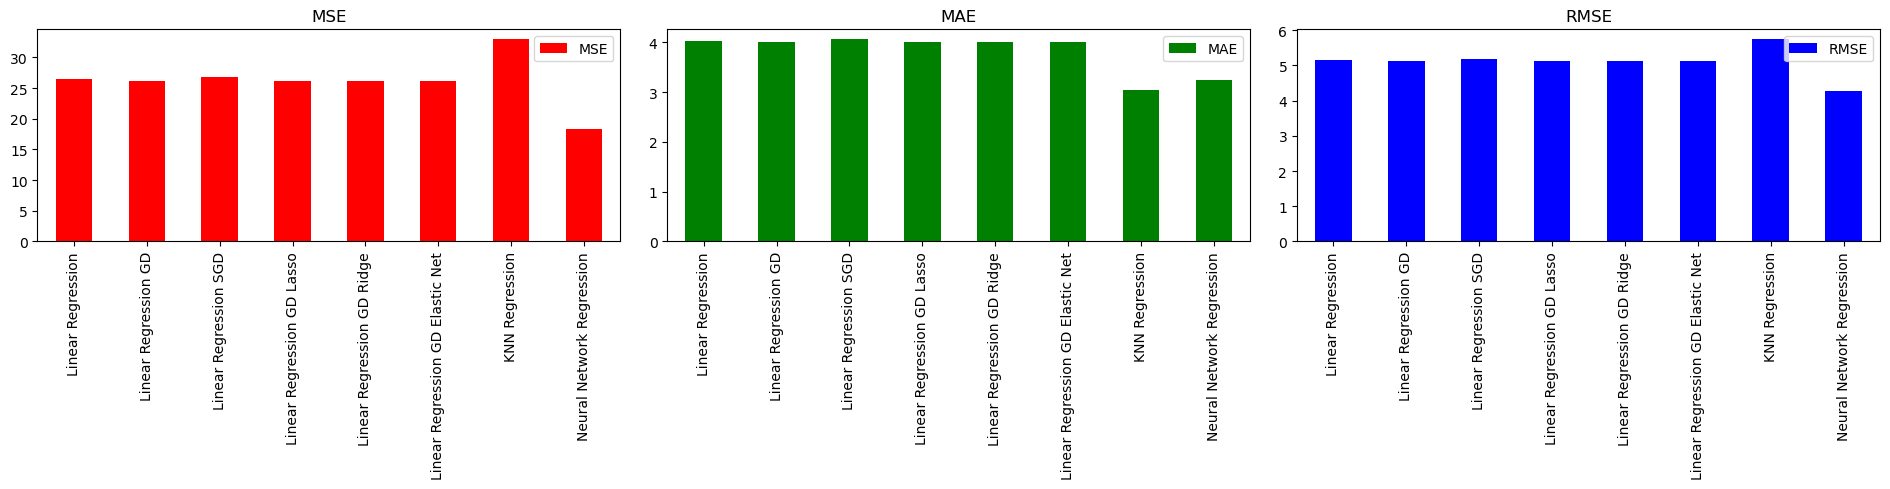

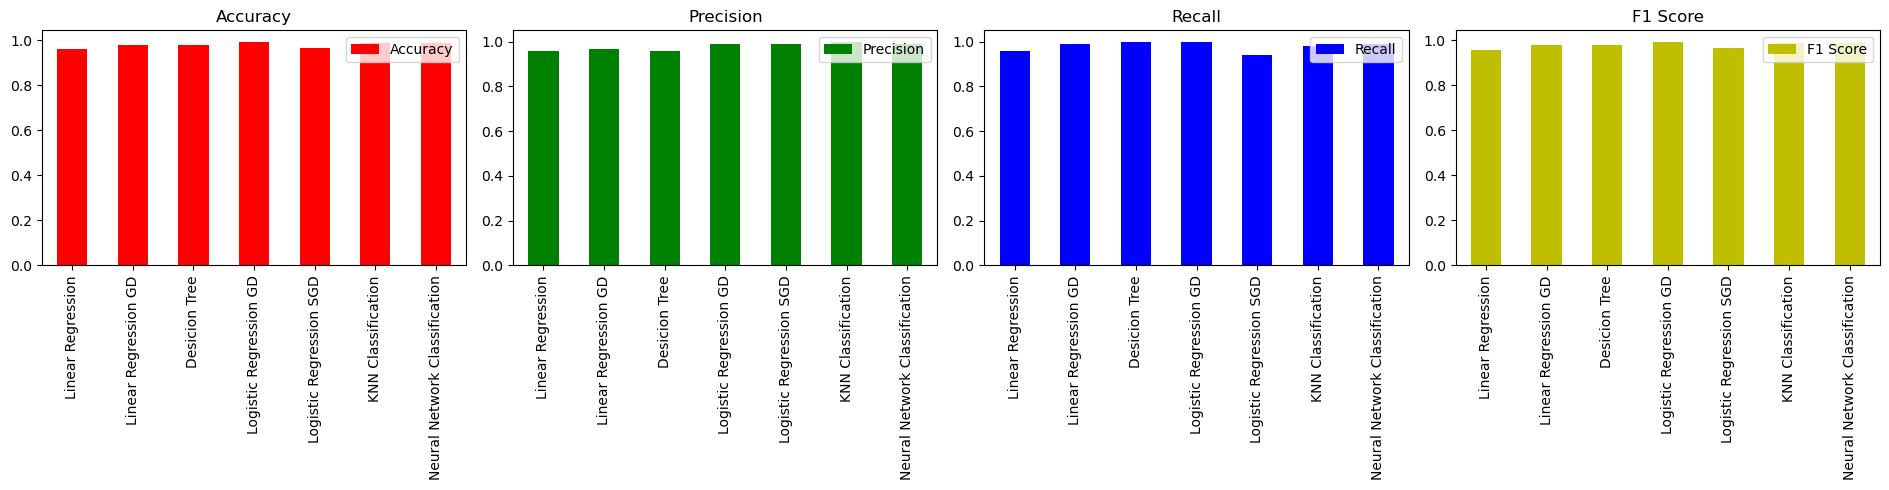

In [185]:
# Plot dei risultati della regressione e della classificazione

def plot_regression_results(regression_results_data,):  # Plotta i risultati della regressione con un bar plot orientato orizzontalmente
    fig, axs = plt.subplots(1, 3, figsize=(19, 5))

    regression_results_data.plot(kind="bar", y="MSE", ax=axs[0], color="r")
    axs[0].set_title("MSE")

    regression_results_data.plot(kind="bar", y="MAE", ax=axs[1], color="g")
    axs[1].set_title("MAE")

    regression_results_data.plot(kind="bar", y="RMSE", ax=axs[2], color="b")
    axs[2].set_title("RMSE")

    plt.tight_layout()
    plt.show()


def plot_classification_results(classification_results_data):
    fig, axs = plt.subplots(1, 4, figsize=(19, 5))

    classification_results_data.plot(kind="bar", y="Accuracy", ax=axs[0], color="r")
    axs[0].set_title("Accuracy")

    classification_results_data.plot(kind="bar", y="Precision", ax=axs[1], color="g")
    axs[1].set_title("Precision")

    classification_results_data.plot(kind="bar", y="Recall", ax=axs[2], color="b")
    axs[2].set_title("Recall")

    classification_results_data.plot(kind="bar", y="F1 Score", ax=axs[3], color="y")
    axs[3].set_title("F1 Score")

    plt.tight_layout()
    plt.show()


plot_regression_results(regression_results_data)
plot_classification_results(classification_results_data)